# Introduction

Welcome to the hands-on Colab notebook for TabPFN!
This code shows how to use TabPFN for large datasets using a random-forest preprocessing.

# Installation

Restart your runtime and rerun the *cell*, if Colab asks for it.

In [ ]:
# # Install sklearn
# !pip install scikit-learn==1.5.2

# # Install TabPFN
# !git clone https://github.com/PriorLabs/tabpfn
# !pip install -e tabpfn

# # TabPFN Community installs optional functionalities around the TabPFN model
# # These include post-hoc ensembles, interpretability tools, and more
# !git clone https://github.com/PriorLabs/tabpfn-extensions
# !pip install -e tabpfn-extensions[post_hoc_ensembles,interpretability,hpo]

# # Install Baselines
# !pip install catboost xgboost

# # Install example datasets
# !pip install datasets
# !pip install statsmodels


UnboundLocalError: cannot access local variable 'child' where it is not associated with a value

**Now Restart the Runtime**

### In order to get the fastest predictions you need to enable GPUs for the notebook:
* Navigate to Edit→Notebook Settings
* select GPU from the Hardware Accelerator drop-down

# Preparation of variables

In [3]:
import pandas as pd
import numpy as np
import regex

def generate_ad_risk_surrogates(ukb_main_df: pd.DataFrame) -> pd.DataFrame:
    """
    Generates a minimal set of surrogates for the 14 Lancet modifiable risk factors for Alzheimer's Disease
    derived from UK Biobank data.

    Args:
        ukb_main_df: A pandas DataFrame containing the raw UK Biobank data.

    Returns:
        A pandas DataFrame with one row per participant and columns for each of the 14 risk factor surrogates,
        where a higher value indicates a higher risk for AD.
    """

    # --- 1. Less Education ---
    # Field 6138: Qualifications
    # Recoding: Higher values indicate lower educational attainment (higher risk)
    education_mapping = {
        1: 6,  # College or University degree
        2: 5,  # A levels/AS levels or equivalent
        3: 4,  # O levels/GCSEs or equivalent
        4: 3,  # CSEs or equivalent
        5: 2,  # NVQ or HND or HNC or equivalent
        6: 1,  # Other professional qualifications eg: nursing, teaching
        -7: np.nan, # None of the above
        -3: np.nan  # Prefer not to answer
    }
    ukb_main_df['risk_less_education'] = ukb_main_df['6138-0.0'].map(education_mapping)
    # Invert the scale so higher is higher risk
    ukb_main_df['risk_less_education'] = 7 - ukb_main_df['risk_less_education']


    # --- 2. Hypertension ---
    # Field 20002: Self-reported non-cancer illness
    # Coding 1071 corresponds to hypertension
    ukb_main_df['risk_hypertension'] = ukb_main_df['20002-0.0'].apply(lambda x: 1 if x == 1071 else 0)


    # --- 3. Hearing Impairment ---
    # Field 2247: Hearing difficulty/problems
    # Recoding: 'Yes' (1) indicates higher risk.
    ukb_main_df['risk_hearing_impairment'] = ukb_main_df['2247-0.0'].apply(lambda x: 1 if x == 1 else 0)


    # --- 4. Smoking ---
    # Field 20116: Smoking status
    # Recoding: Current smokers (2) and previous smokers (1) have higher risk.
    smoking_mapping = {
        0: 0,  # Never
        1: 1,  # Previous
        2: 2,  # Current
        -3: np.nan # Prefer not to answer
    }
    ukb_main_df['risk_smoking'] = ukb_main_df['20116-0.0'].map(smoking_mapping)


    # --- 5. Obesity ---
    # Field 21001: Body mass index (BMI)
    # Higher BMI is a direct risk factor.
    ukb_main_df['risk_obesity'] = ukb_main_df['21001-0.0']


    # --- 6. Depression ---
    # Field 20126: Self-reported depression
    ukb_main_df['risk_depression'] = ukb_main_df['20126-0.0'].apply(lambda x: 1 if x == 1 else 0)


    # --- 7. Physical Inactivity ---
    # Field 22040: International Physical Activity Questionnaire (IPAQ) activity level
    # Recoding: Inverting the scale as higher IPAQ score is protective.
    physical_activity_mapping = {
        3: 1, # High
        2: 2, # Moderate
        1: 3, # Low
    }
    ukb_main_df['risk_physical_inactivity'] = ukb_main_df['22040-0.0'].map(physical_activity_mapping)


    # --- 8. Diabetes ---
    # Field 2443: Doctor diagnosed diabetes
    ukb_main_df['risk_diabetes'] = ukb_main_df['2443-0.0'].apply(lambda x: 1 if x == 1 else 0)


    # --- 9. Social Isolation ---
    # Field 1031: Frequency of friend/family visits
    # Recoding: Less frequent visits indicate higher isolation (higher risk).
    social_isolation_mapping = {
        1: 5, # Daily or almost daily
        2: 4, # 2-4 times a week
        3: 3, # Once a week
        4: 2, # 1-3 times a month
        5: 1, # Never or almost never
        -7: np.nan, # None of the above
        -3: np.nan  # Prefer not to answer
    }
    ukb_main_df['risk_social_isolation'] = ukb_main_df['1031-0.0'].map(social_isolation_mapping)


    # --- 10. Excessive Alcohol Consumption ---
    # Field 1558: Alcohol intake frequency
    # Recoding: Higher frequency indicates higher risk.
    alcohol_mapping = {
        1: 6,  # Daily or almost daily
        2: 5,  # Three or four times a week
        3: 4,  # Once or twice a week
        4: 3,  # One to three times a month
        5: 2,  # Special occasions only
        6: 1,  # Never
        -3: np.nan  # Prefer not to answer
    }
    ukb_main_df['risk_alcohol'] = ukb_main_df['1558-0.0'].map(alcohol_mapping)


    # --- 11. Traumatic Brain Injury ---
    # Field 20002: Self-reported non-cancer illness
    # Coding 1081 corresponds to head injury
    ukb_main_df['risk_tbi'] = ukb_main_df['20002-0.0'].apply(lambda x: 1 if x == 1081 else 0)


    # --- 12. Air Pollution ---
    # Field 24003: Nitrogen dioxide air pollution; 2010
    # Higher value is a direct risk.
    ukb_main_df['risk_air_pollution'] = ukb_main_df['24003-0.0']


    # --- 13. High Cholesterol ---
    # Field 20002: Self-reported non-cancer illness
    # Coding 1473 corresponds to high cholesterol
    ukb_main_df['risk_high_cholesterol'] = ukb_main_df['20002-0.0'].apply(lambda x: 1 if x == 1473 else 0)


    # --- 14. Uncorrected Vision Loss ---
    # Field 6142: Wears glasses or contact lenses
    # Assuming those who need glasses but don't wear them are at higher risk.
    # This is a simplification; a more detailed assessment would be needed.
    # Recoding: 1 if 'Yes', 0 if 'No'
    ukb_main_df['risk_vision_loss'] = ukb_main_df['6142-0.0'].apply(lambda x: 1 if x == 1 else 0)


    # --- Consolidate Risk Factors ---
    risk_factors_df = ukb_main_df[[
        'eid',
        'risk_less_education',
        'risk_hypertension',
        'risk_hearing_impairment',
        'risk_smoking',
        'risk_obesity',
        'risk_depression',
        'risk_physical_inactivity',
        'risk_diabetes',
        'risk_social_isolation',
        'risk_alcohol',
        'risk_tbi',
        'risk_air_pollution',
        'risk_high_cholesterol',
        'risk_vision_loss'
    ]].copy()

    return risk_factors_df

if __name__ == '__main__':
    # This is a placeholder for loading the actual UK Biobank data.
    # Researchers with access should replace this with their data loading mechanism.
    # For demonstration, we create a dummy dataframe.
    dummy_data = {
        'eid': range(100),
        '6138-0.0': np.random.randint(1, 7, 100),
        '20002-0.0': np.random.choice([1071, 1081, 1473, 9999], 100),
        '2247-0.0': np.random.randint(0, 2, 100),
        '20116-0.0': np.random.randint(0, 3, 100),
        '21001-0.0': np.random.uniform(18, 40, 100),
        '20126-0.0': np.random.randint(0, 2, 100),
        '22040-0.0': np.random.randint(1, 4, 100),
        '2443-0.0': np.random.randint(0, 2, 100),
        '1031-0.0': np.random.randint(1, 6, 100),
        '1558-0.0': np.random.randint(1, 7, 100),
        '24003-0.0': np.random.uniform(10, 50, 100),
        '6142-0.0': np.random.randint(0, 2, 100)
    }
    ukb_dummy_df = pd.DataFrame(dummy_data)

    # Generate the risk surrogates
    ad_risk_surrogates = generate_ad_risk_surrogates(ukb_dummy_df)

    # Display the first few rows of the generated surrogates
    print(ad_risk_surrogates.head())

   eid  risk_less_education  risk_hypertension  risk_hearing_impairment  \
0    0                  5.0                  0                        0   
1    1                  3.0                  0                        1   
2    2                  3.0                  0                        0   
3    3                  4.0                  1                        0   
4    4                  1.0                  0                        0   

   risk_smoking  risk_obesity  risk_depression  risk_physical_inactivity  \
0           2.0     22.920679                0                         1   
1           0.0     38.610137                0                         3   
2           1.0     18.303471                1                         3   
3           0.0     32.707632                1                         1   
4           1.0     23.873357                0                         1   

   risk_diabetes  risk_social_isolation  risk_alcohol  risk_tbi  \
0              1         

# Plot APOE Volcano Plots

In [27]:
# Load the 'electricity' dataset from OpenML (tabular data with ~45,000 samples)
import torch, torch_frame

OLINK=pd.read_csv('OLINK_APOE.csv')
OLINK.set_index('eid', inplace=True)
OLINK.drop(columns=['Unnamed: 0'], inplace=True)
OLINK_cols = list(OLINK.columns[:-1])

RF=pd.read_csv('Olink_cohort_APOE_Dementia.csv')
RF.set_index('eid', inplace=True)
RF.drop(columns=['Unnamed: 0'], inplace=True)
RF.drop(columns=['Unnamed: 0.1'], inplace=True)

df=OLINK.merge(RF.loc[:,['A4','Dementia_Status','Sex','Age_i0']],suffixes =('', '_RF'), left_index=True, right_index=True, how='inner')

cols2stype={}
for a in df.columns:
    if df[a].dtype==np.float64:
        cols2stype[a]=torch_frame.numerical
    elif df[a].dtype==np.int64:
        cols2stype[a]=torch_frame.numerical
    else:
        cols2stype[a]=torch_frame.categorical
    

# # Load the 'Covertype' dataset from OpenML (tabular data with ~580,000 samples)
# #df = fetch_openml('Covertype', version=3, as_frame=True)

# X, y = df.iloc[:,:500], df['A4']

# # Encode target labels to classes
# le = LabelEncoder()
# y = le.fit_transform(y)

# # Convert all categorical columns to numeric
# for col in X.select_dtypes(['category']).columns:
#     X[col] = X[col].cat.codes

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# # Print dataset description
# #display(Markdown(df['DESCR']))

# display(X)

/tmp/ipykernel_203591/3461149395.py:9: DtypeWarning: Columns (154) have mixed types. Specify dtype option on import or set low_memory=False.
  RF=pd.read_csv('Olink_cohort_APOE_Dementia.csv')


In [ ]:
df_results['FDR']

In [3]:
import pandas as pd
df_assay_info = pd.read_csv('/mnt/data/eduff/biobank/Proteomics/OLINK/olink_assay.dat', sep='\t')

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm


# --- Step 2: Load and Prepare Panel Data ---

try:
    df_assay_info = pd.read_csv('/mnt/data/eduff/biobank/Proteomics/OLINK/olink_assay.dat', sep='\t')
    df_assay_info['Assay']=df_assay_info['Assay'].str.lower()
except FileNotFoundError:
    print("Error: 'olink_assay.dat' not found. Please download it and place it in the working directory.")
    exit()

# Get a list of all protein columns in the main dataframe
#protein_cols = [col for col in df.columns if col.startswith('OID')]
protein_cols= OLINK_cols
# --- Step 3: Calculate Fold Change and P-values ---

# Define the two groups for comparison
group1 = df[df['A4'] == 0]
group2 = df[df['A4'] == 1]

results = []

for protein in protein_cols:
    # Prepare data for this protein
    tmp = df[[protein, 'A4', 'Age_i0', 'Sex']].dropna()
    # Encode Sex if not numeric
    if tmp['Sex'].dtype == object:
        tmp['Sex'] = tmp['Sex'].astype('category').cat.codes
    # Model: protein ~ A4 + Age_i0 + Sex
    try:
        model = sm.OLS(tmp[protein], sm.add_constant(tmp[['A4', 'Age_i0', 'Sex']])).fit()
        coef = model.params['A4']
        pval = model.pvalues['A4']
        # Log2 fold change (mean difference, since NPX is log2 scale)
        group1 = tmp[tmp['A4'] == 0][protein]
        group2 = tmp[tmp['A4'] == 1][protein]
        log2fc = group2.mean() - group1.mean()
        results.append({
            'Assay': protein,
            'log2_fold_change': log2fc,
            'p_value': pval,
            'coef_A4': coef
        })
    except Exception as e:
        print(e)
        results.append({
            'Assay': protein,
            'log2_fold_change': np.nan,
            'p_value': np.nan,
            'coef_A4': np.nan
        })

df_results = pd.DataFrame(results)

# Add -log10(p-value) for plotting
df_results['-log10_p_value'] = -np.log10(df_results['p_value'])

# Merge results with panel information
df_results = df_results.merge(df_assay_info, on='Assay', how='left')

# Calculate FDR (Benjamini-Hochberg) for each panel
df_results['FDR'] = np.nan
for panel in df_results['Panel'].dropna().unique():
    mask = df_results['Panel'] == panel
    pvals = df_results.loc[mask, 'p_value']
    _, fdr, _, _ = multipletests(pvals, method='fdr_bh')
    df_results.loc[mask, 'FDR'] = fdr

print(f"\nSuccessfully calculated statistics for {len(df_results)} proteins (age and sex adjusted, FDR per panel).")


# --- Step 4: Define Volcano Plot Function ---

def create_volcano_plot(data, panel_name, lfc_threshold=0.05, p_val_threshold=0.05):
    """Generates and saves a single volcano plot."""
    
    # Add significance column
    data['significance'] = 'Not Significant'
    data.loc[(data['log2_fold_change'] > lfc_threshold) & (data['FDR'] < p_val_threshold), 'significance'] = 'Upregulated'
    data.loc[(data['log2_fold_change'] < -lfc_threshold) & (data['FDR'] < p_val_threshold), 'significance'] = 'Downregulated'

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 10))

    # Create scatter plot
    sns.scatterplot(
        data=data,
        x='log2_fold_change',
        y='-log10_p_value',
        hue='significance',
        palette={'Upregulated': 'red', 'Downregulated': 'blue', 'Not Significant': 'grey'},
        s=40,
        alpha=0.7,
        ax=ax,
        edgecolor='k',
        linewidth=0.5
    )

    # Add threshold lines
    ax.axhline(y=-np.log10(p_val_threshold), color='black', linestyle='--', linewidth=1)
    ax.axvline(x=lfc_threshold, color='black', linestyle='--', linewidth=1)
    ax.axvline(x=-lfc_threshold, color='black', linestyle='--', linewidth=1)
    
    # Add labels to the most significant proteins
    texts = []
    # Sort by p-value and take top 10 significant proteins to label
    label_data = data[data['significance'] != 'Not Significant'].sort_values('p_value').head(10)
    for i, row in label_data.iterrows():
        texts.append(ax.text(row['log2_fold_change'], row['-log10_p_value'], row['Assay'], fontsize=9))
    
    # Use adjustText to prevent labels from overlapping
    if texts:
        adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black', lw=0.5))

    # Set titles and labels
    ax.set_title(f'Volcano Plot for {panel_name} Panel', fontsize=16, fontweight='bold')
    ax.set_xlabel('Log2 Fold Change (Case vs Control)', fontsize=12)
    ax.set_ylabel('-log10(P-value)', fontsize=12)
    ax.legend(title='Significance', frameon=True)

    plt.tight_layout()
    plt.savefig(f'volcano_plot_{panel_name.replace(" ", "_")}.png', dpi=300)
    plt.show()




Successfully calculated statistics for 2923 proteins (age and sex adjusted, FDR per panel).


/home/eduff/miniconda3/envs/pytorch/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)



Generating volcano plot for the Inflammation II panel...


/home/eduff/miniconda3/envs/pytorch/lib/python3.13/site-packages/matplotlib/transforms.py:357: RuntimeWarning: invalid value encountered in scalar subtract
  return points[1, 1] - points[0, 1]


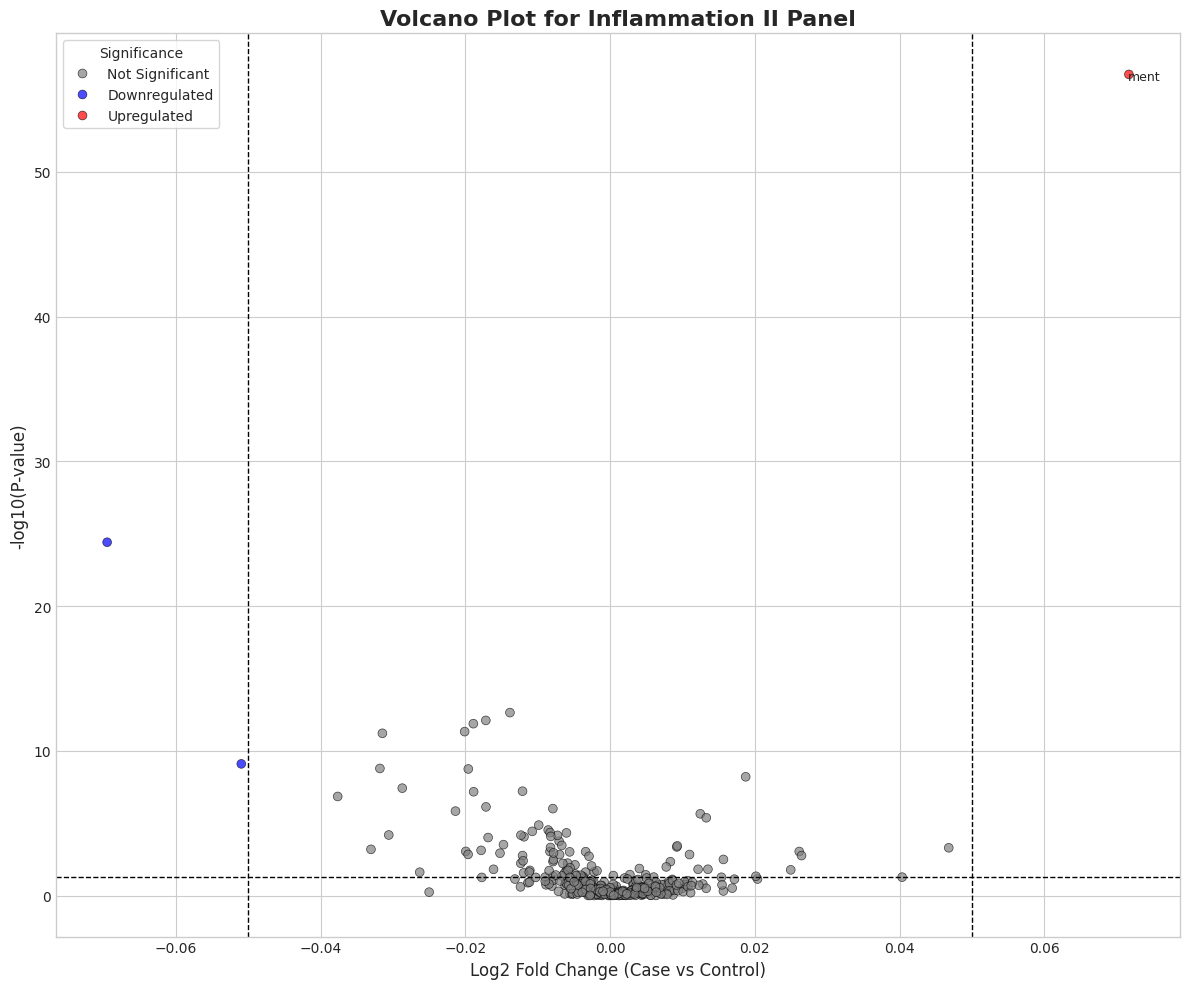


Generating volcano plot for the Cardiometabolic II panel...


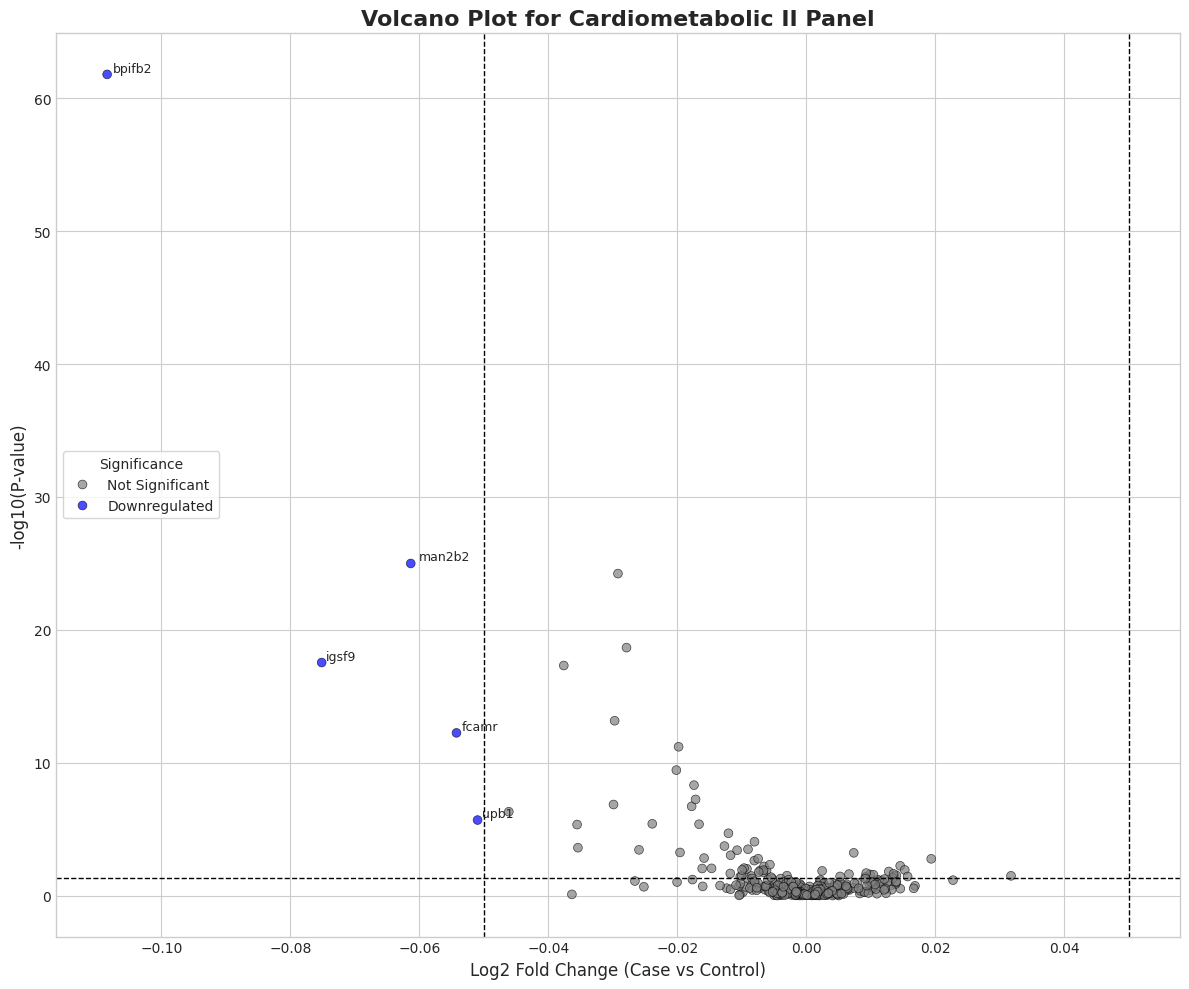


Generating volcano plot for the Oncology panel...


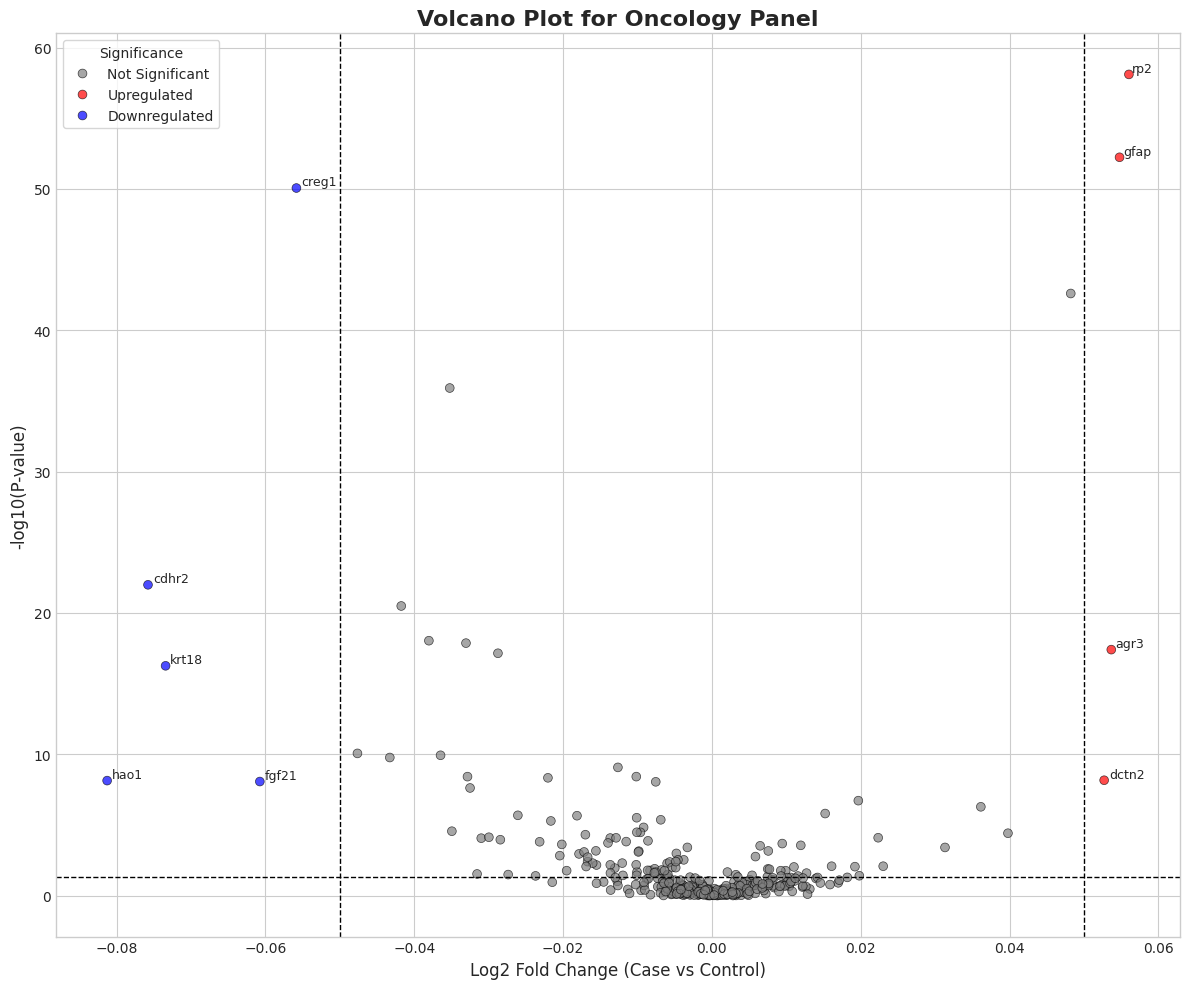


Generating volcano plot for the Neurology panel...


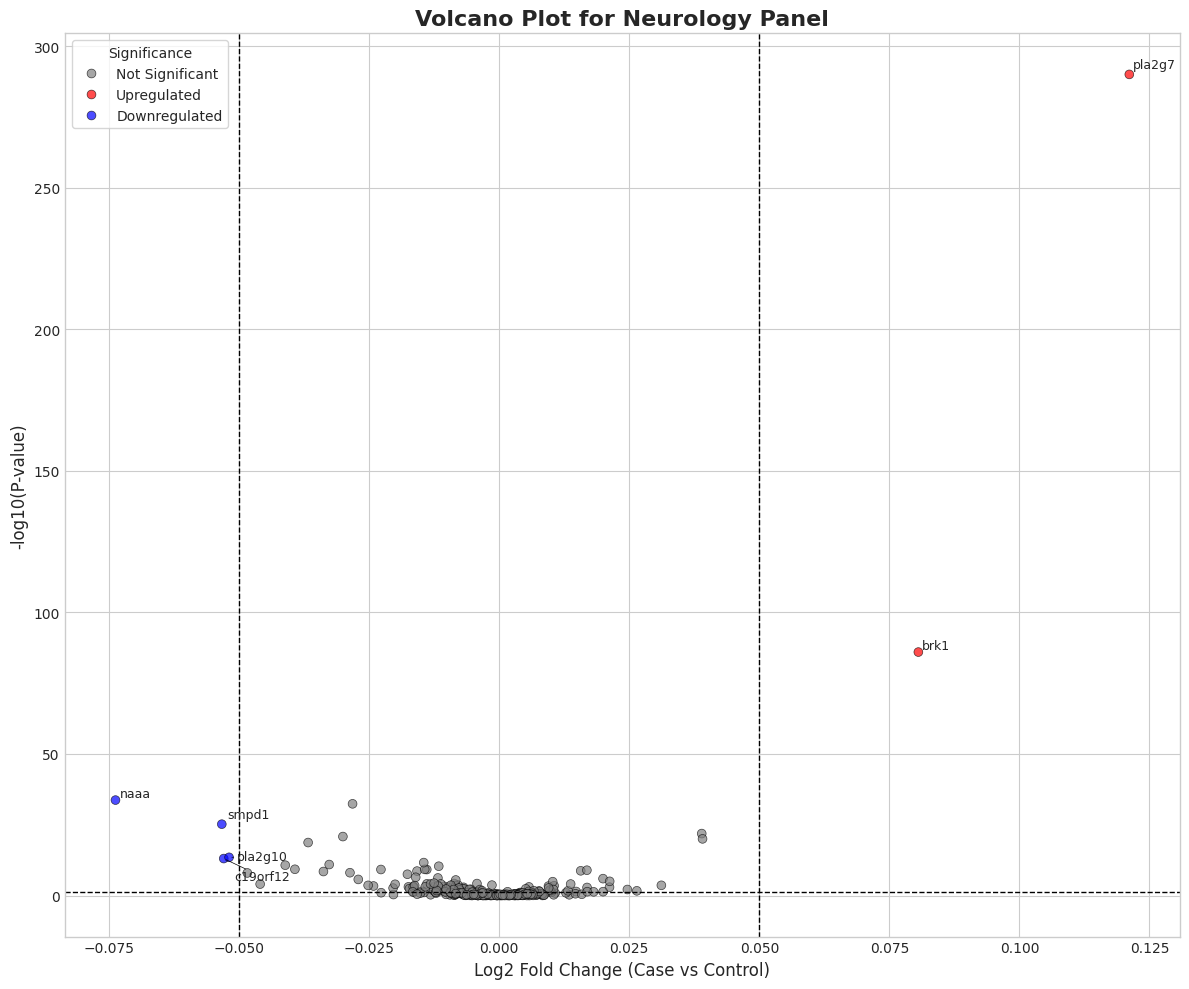


Generating volcano plot for the Oncology II panel...


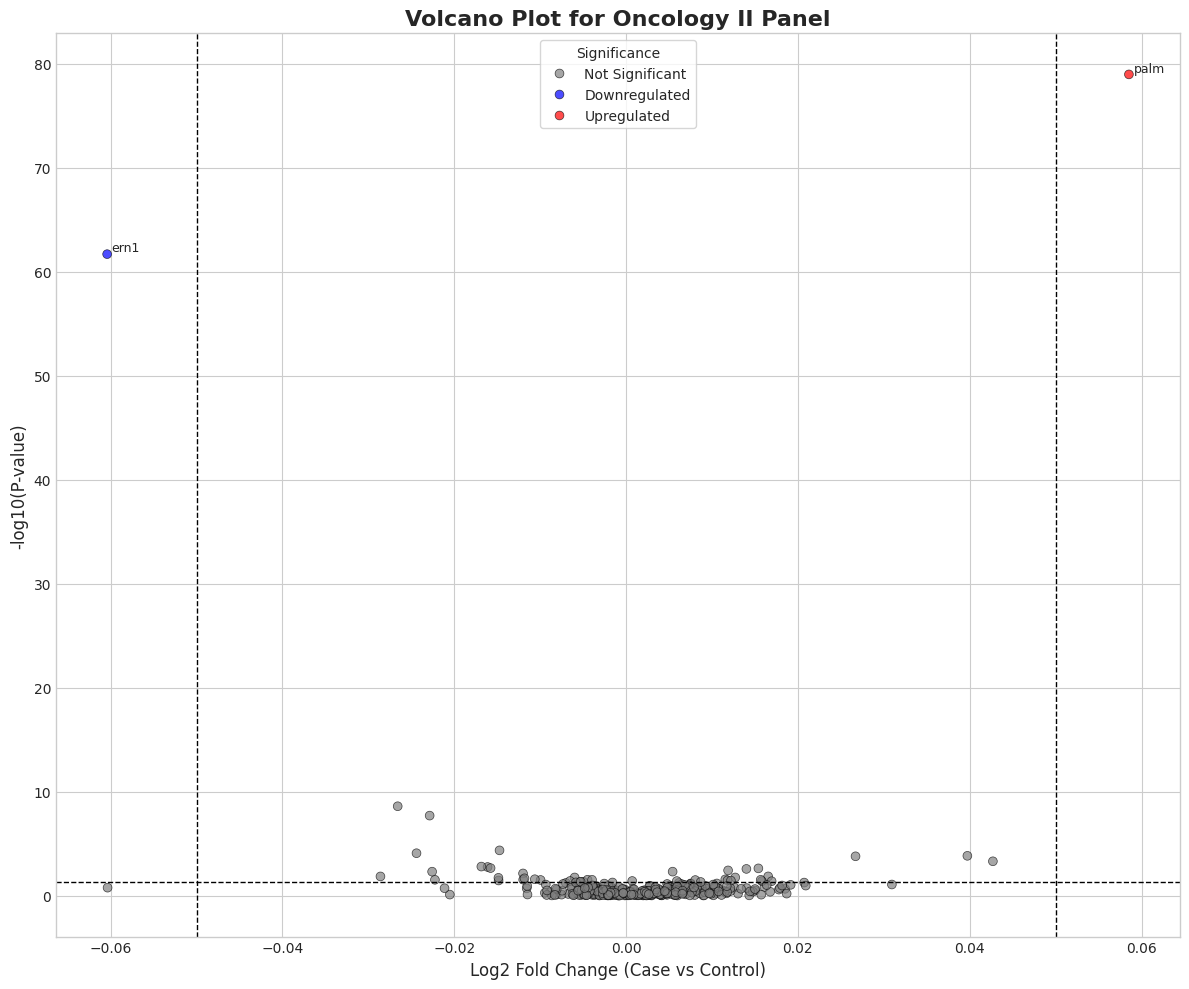


Generating volcano plot for the Cardiometabolic panel...


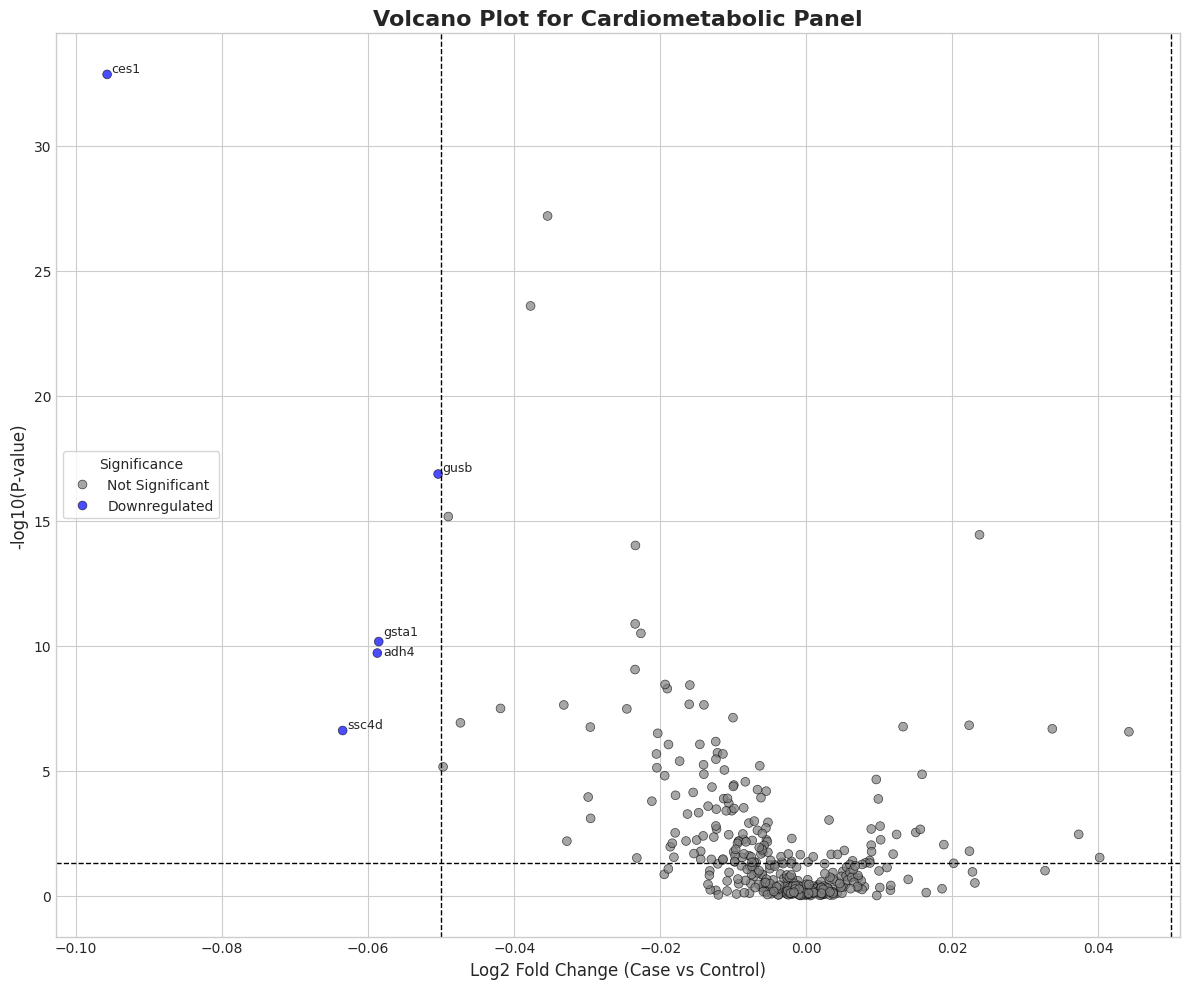


Generating volcano plot for the Inflammation panel...


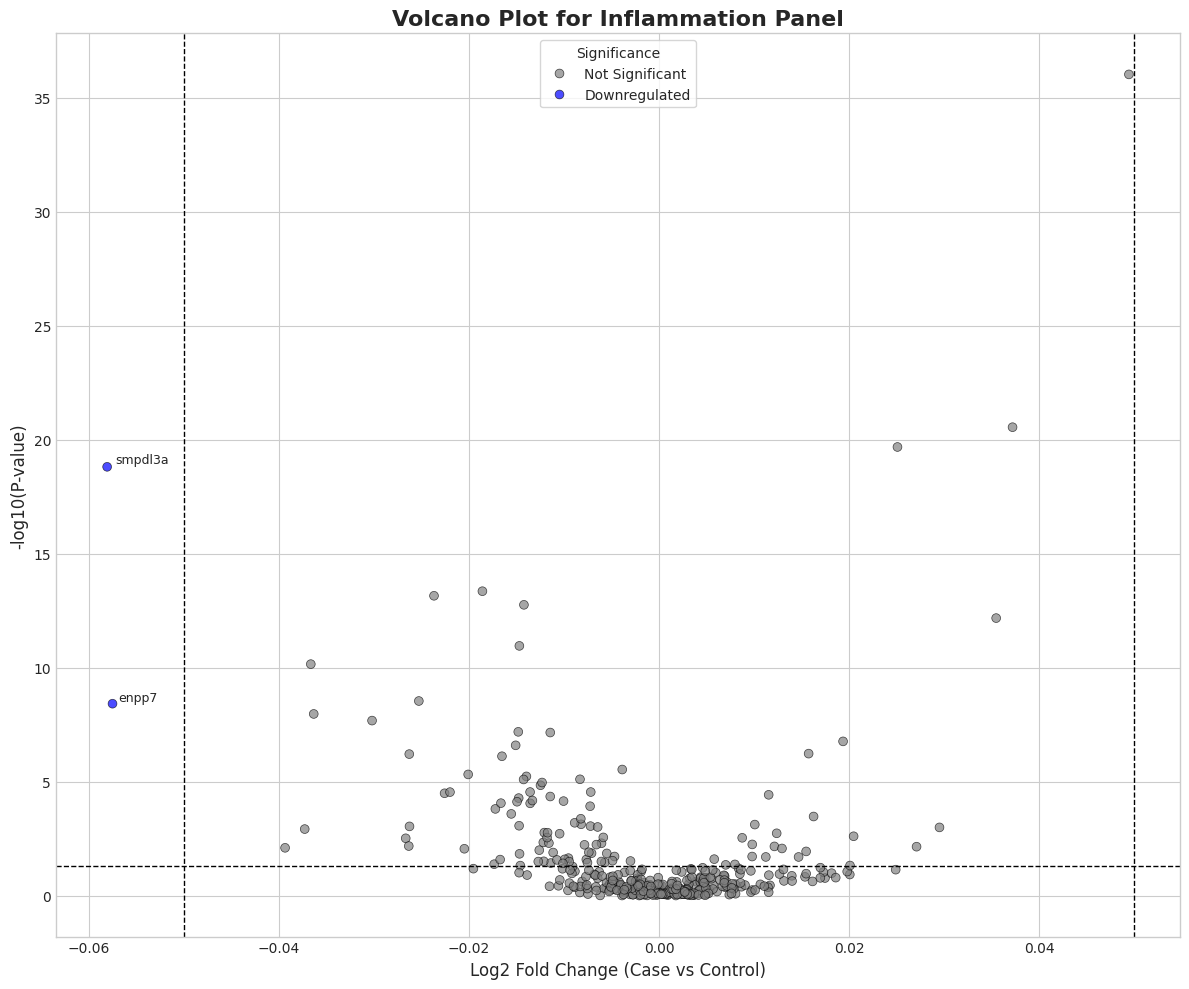


Generating volcano plot for the Neurology II panel...


/home/eduff/miniconda3/envs/pytorch/lib/python3.13/site-packages/matplotlib/transforms.py:357: RuntimeWarning: invalid value encountered in scalar subtract
  return points[1, 1] - points[0, 1]


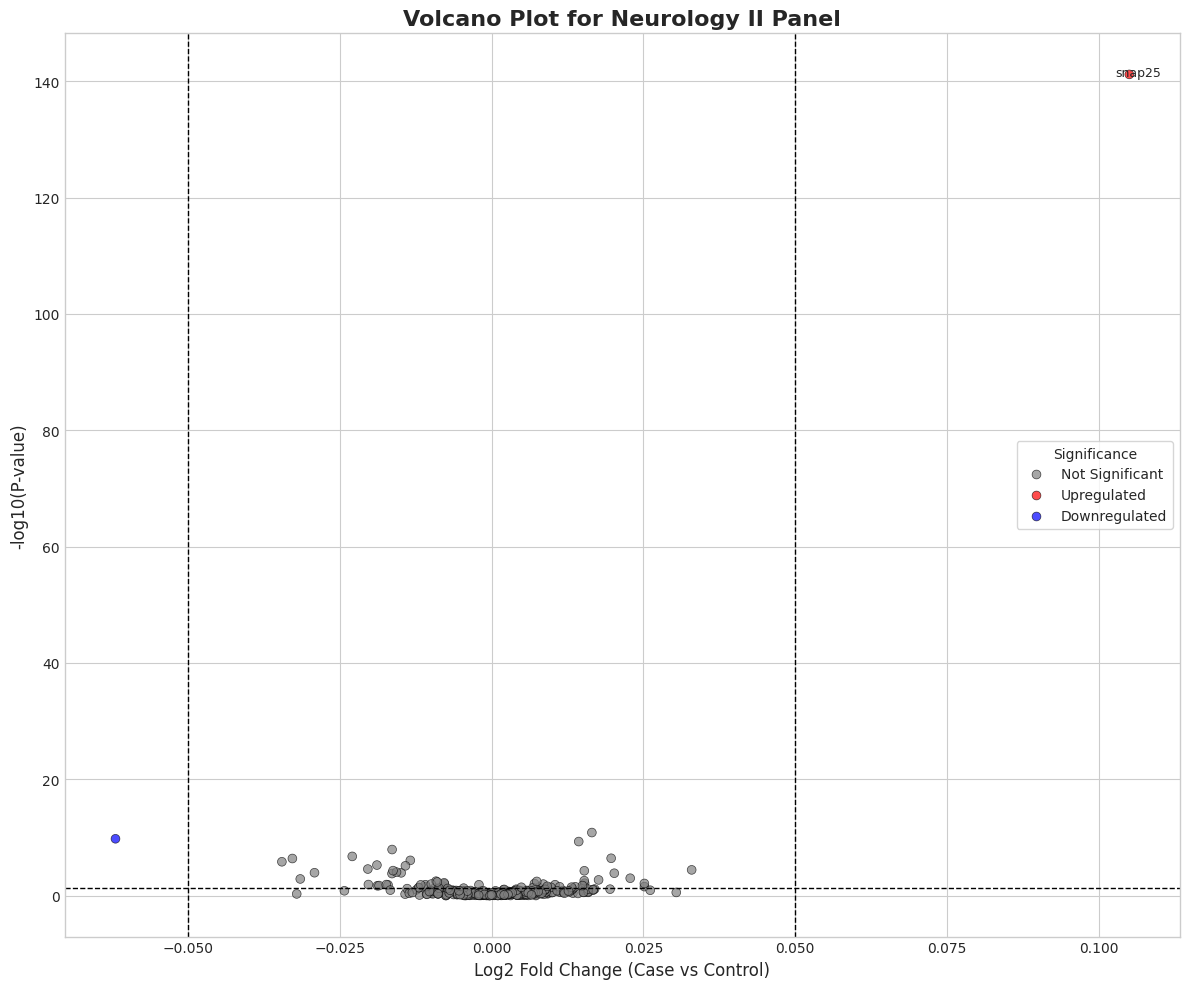

In [58]:

# --- Step 5: Generate a Plot for Each Panel ---

# Get unique panels from the results
unique_panels = df_results['Panel'].unique()

for panel in unique_panels:
    if pd.isna(panel): continue # Skip any proteins that didn't map to a panel
    
    print(f"\nGenerating volcano plot for the {panel} panel...")
    panel_data = df_results[df_results['Panel'] == panel].copy()
    
    if not panel_data.empty:
        create_volcano_plot(panel_data, panel_name=panel)
    else:
        print(f"No data found for panel: {panel}")

# Example script

# Cross Validation



In [59]:
import gen_risk_surrogates as gen_risk_surrogates

In [109]:
df4['24003-0.0']

array([17.56, 28.67, 21.13, ..., 48.4 , 55.21, 91.52], shape=(3786,))

In [60]:
out=gen_risk_surrogates.generate_ad_risk_surrogates(ukb_main_df=df4)
out2=gen_risk_surrogates.generate_dietary_risk_surrogates(ukb_main_df=df4)
out3=gen_risk_surrogates.gen_lipid_risk_surrogates(ukb_main_df=df4)

out.loc[RF.index,['APOE', 'Age_i0','Dementia_Status']]=RF[['APOE', 'Age_i0','Dementia_Status']]
out2.loc[RF.index,['APOE', 'Age_i0','Dementia_Status']]=RF[['APOE', 'Age_i0','Dementia_Status']]
out3.loc[RF.index,['APOE', 'Age_i0','Dementia_Status']]=RF[['APOE', 'Age_i0','Dementia_Status']]


NameError: name 'df4' is not defined

In [113]:
tmp

,risk_saturated_fat,risk_simple_carbs,risk_low_fiber,risk_low_omega3
eid,,,,
1000037,6.0,1.0,1.0,5.0
1000221,8.0,3.0,1.0,3.0
1000326,7.0,0.0,3.0,4.0
1000662,6.0,0.0,5.0,NaN
1000823,10.0,0.0,3.0,4.0
...,...,...,...,...
6023823,8.0,0.0,1.0,NaN
6023922,6.0,0.0,3.0,NaN
6024013,9.0,0.0,5.0,4.0


In [70]:
out.loc[RF.index,['APOE', 'Age_i0','Dementia_Status']]=RF[['APOE', 'Age_i0','Dementia_Status']]


In [85]:
ll=list(out['APOE'].dropna().unique()).sort()
ll

In [96]:
ll=list(out['APOE'].dropna().unique())

In [119]:
out2['Dementia_Status'].value_counts()

Dementia_Status
0.0    51432
1.0     1581
Name: count, dtype: int64

/tmp/ipykernel_166033/1967469502.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(apoe_groups))


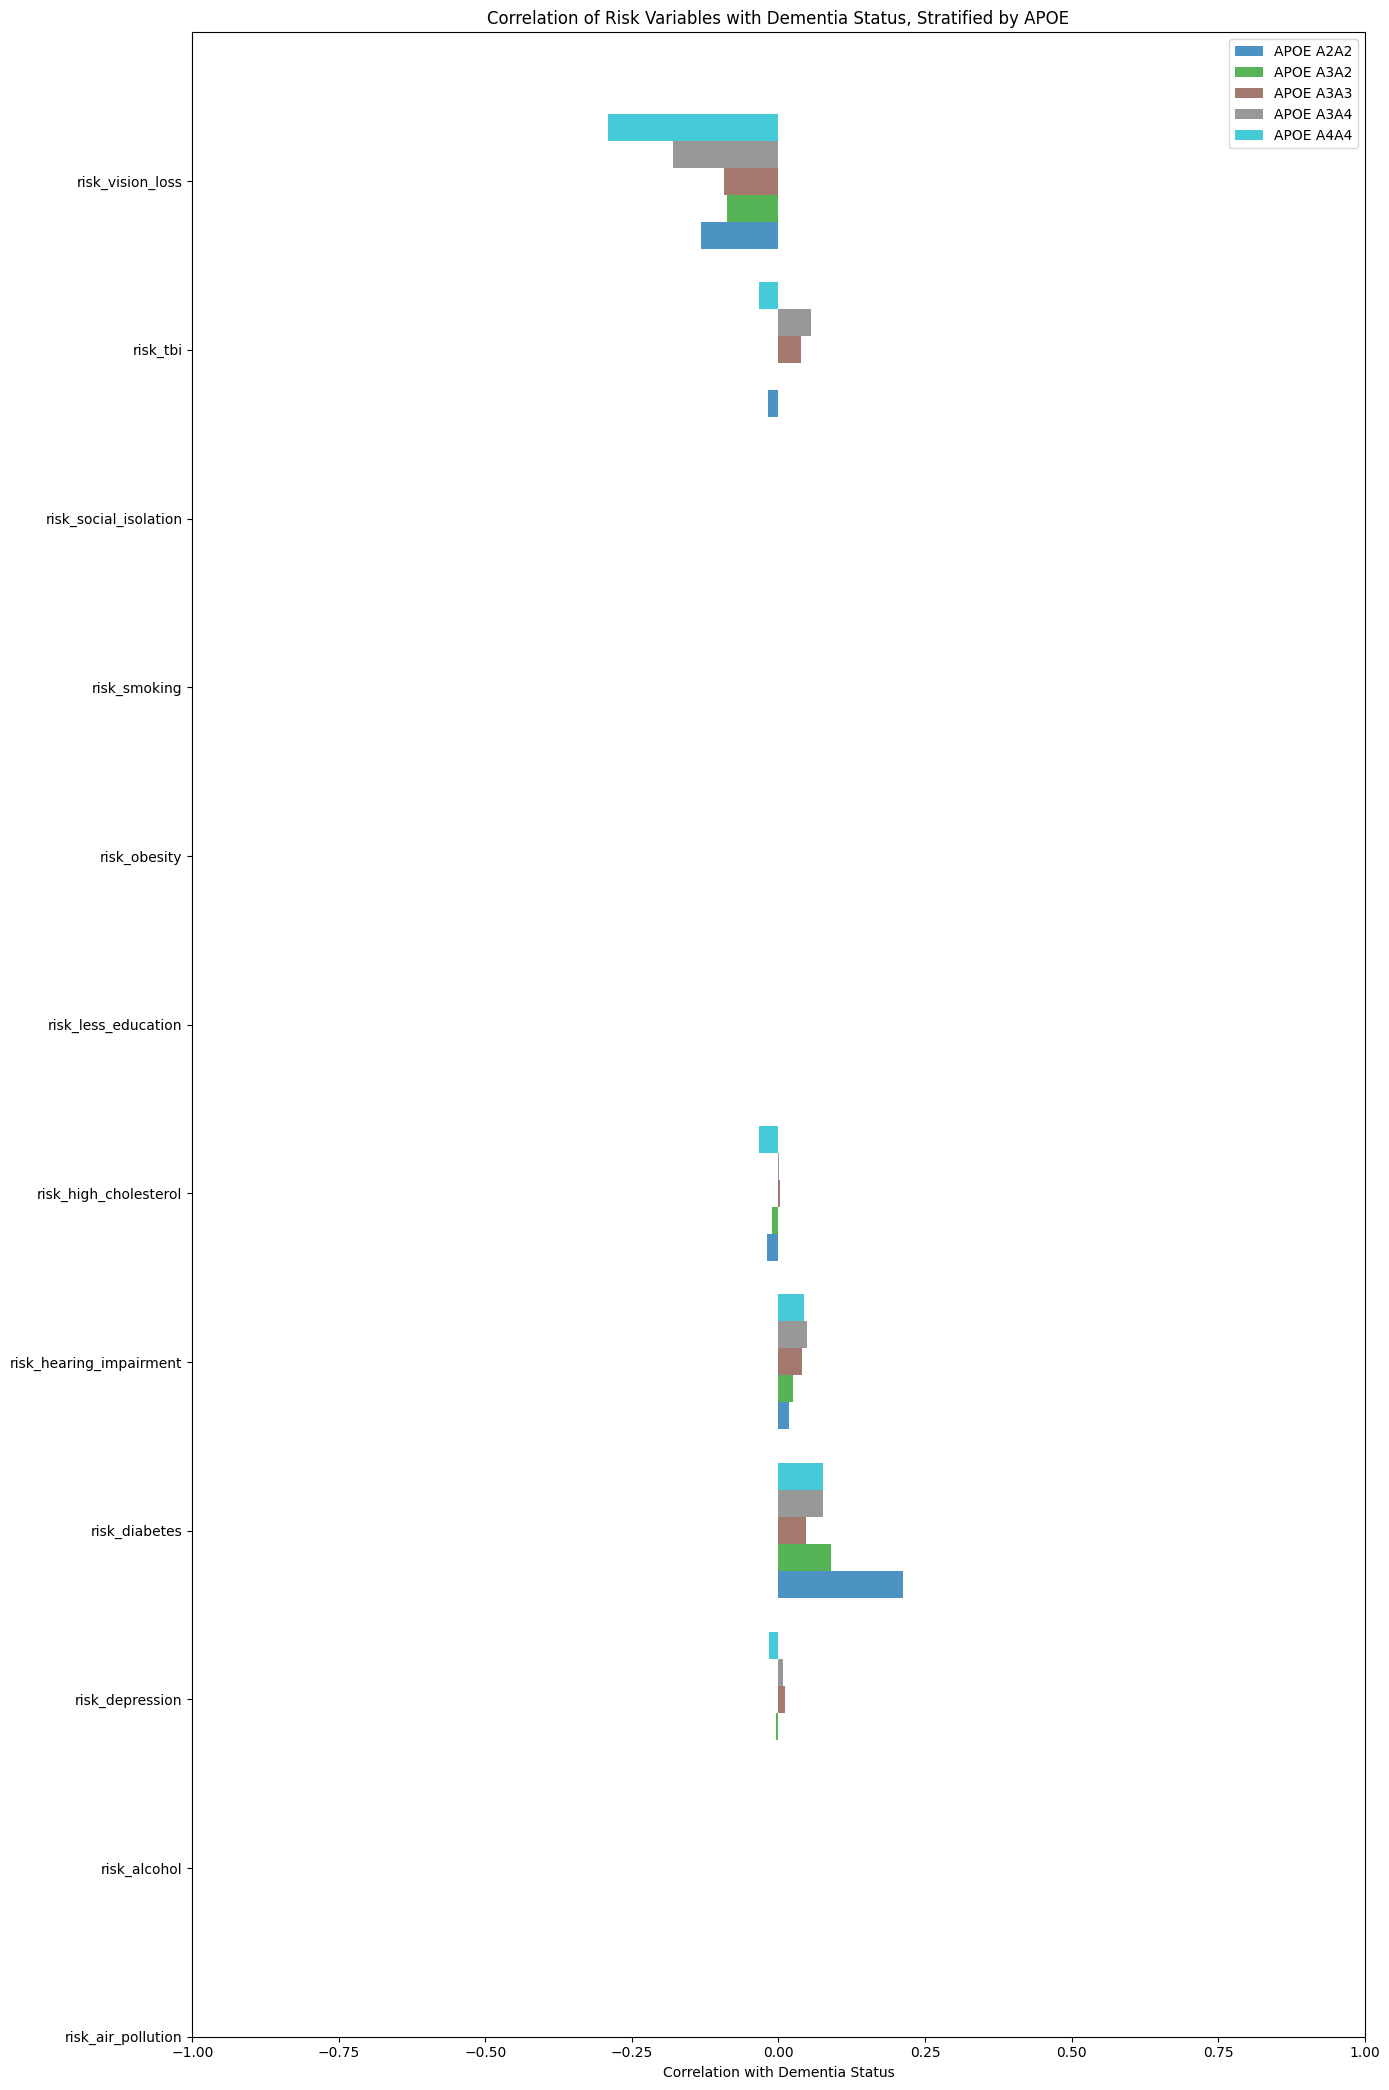

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, pointbiserialr
out = out.copy()
# Assume 'out' contains risk variables, 'Dementia_Status', and 'APOE'
risk_vars = [col for col in out.columns if (col not in ['APOE', 'Age_i0','Dementia_Status'])]
apoe_groups = list(out['APOE'].dropna().unique())
apoe_groups.sort()
cor_results = []

for apoe in apoe_groups:
    subset = out[out['APOE'] == apoe]
    for var in risk_vars:
        # Only compute if there is variance in both columns
        if subset[var].nunique() > 1 and subset['Dementia_Status'].nunique() > 1:
            # Use point-biserial correlation for binary outcome
            corr, pval = pointbiserialr(subset['Dementia_Status'], subset[var])
            cor_results.append({'APOE': apoe, 'Variable': var, 'Correlation': corr, 'pval': pval})

cor_df = pd.DataFrame(cor_results)


plt.figure(figsize=(14, 1.5 * len(risk_vars)))

risk_vars_sorted = sorted(set(cor_df['Variable']))
bar_height = 0.8 / len(apoe_groups)

yticks = []
yticklabels = []

# Assign a color to each APOE group, consistent across all bars
from matplotlib import cm
colors = cm.get_cmap('tab10', len(apoe_groups))
apoe_color_map = {apoe: colors(i) for i, apoe in enumerate(apoe_groups)}

for i, var in enumerate(risk_vars_sorted):
    for j, apoe in enumerate(apoe_groups):
        plot_df = cor_df[(cor_df['Variable'] == var) & (cor_df['APOE'] == apoe)]
        if not plot_df.empty:
            y = i + (j - len(apoe_groups)/2) * bar_height + bar_height/2
            plt.barh(
                y,
                plot_df['Correlation'].values[0],
                height=bar_height,
                color=apoe_color_map[apoe],
                label=f'APOE {apoe}' if (i == 0) else "",
                alpha=0.8
            )
    yticks.append(i)
    yticklabels.append(var)

plt.yticks(yticks, yticklabels)
plt.xlabel('Correlation with Dementia Status')
plt.title('Correlation of Risk Variables with Dementia Status, Stratified by APOE')
plt.xlim(-1, 1)
# Only show one legend entry per APOE group
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.tight_layout()
plt.show()

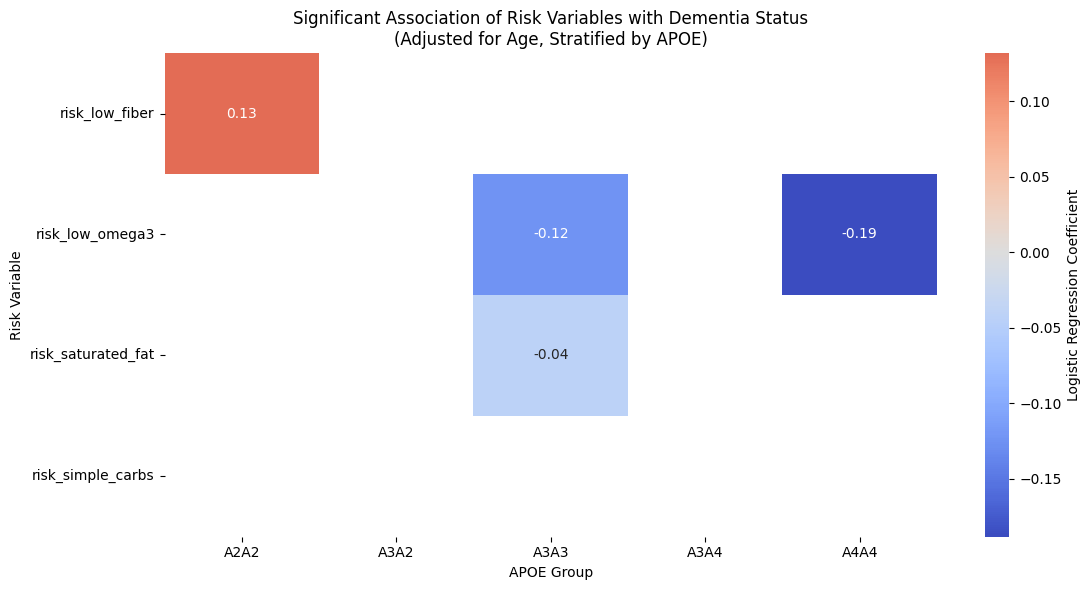

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import logit

# Assuming 'out' is the DataFrame containing risk variables, APOE, Age_i0, and Dementia_Status
out=df.copy()
# Identify risk variables
risk_vars = [col for col in out.columns if col not in ['APOE', 'Age_i0', 'Dementia_Status']]
apoe_groups = sorted(out['APOE'].dropna().unique())

results = []

# For each APOE group, run logistic regression for each risk variable, controlling for age, Sex
for apoe in apoe_groups:
    subset = out[out['APOE'] == apoe].dropna(subset=['Dementia_Status', 'Age_i0','Sex'])
    for var in risk_vars:
        data = subset[[var, 'Dementia_Status', 'Age_i0']].dropna()
        if data[var].nunique() > 1 and data['Dementia_Status'].nunique() > 1:
            try:
                model = logit(f"Dementia_Status ~ {var} + Age_i0", data=data).fit(disp=0)
                pval = model.pvalues.get(var, np.nan)
                coef = model.params.get(var, np.nan)
                results.append({
                    'APOE': apoe,
                    'Variable': var,
                    'Coef': coef,
                    'Pval': pval
                })
            except Exception as e:
                continue

results_df = pd.DataFrame(results)

# Mark significant associations (p < 0.05)
results_df['Significant'] = results_df['Pval'] < 0.1

# Pivot for heatmap
heatmap_data = results_df.pivot(index='Variable', columns='APOE', values='Coef')

# Mask non-significant
mask = ~results_df.pivot(index='Variable', columns='APOE', values='Significant').astype(bool)

plt.figure(figsize=(1.5*len(apoe_groups)+4, 0.5*len(risk_vars)+4))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    mask=mask,
    cbar_kws={'label': 'Logistic Regression Coefficient'}
)
plt.title('Significant Association of Risk Variables with Dementia Status\n(Adjusted for Age, Stratified by APOE)')
plt.ylabel('Risk Variable')
plt.xlabel('APOE Group')
plt.tight_layout()
plt.show()
plt.show()

In [124]:
import os

# Setup Imports
import pandas as pd
import numpy as np

from sklearn.datasets import load_breast_cancer, load_diabetes, load_iris
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import (
    accuracy_score,
    mean_absolute_error,
    mean_squared_error,
    root_mean_squared_error,
    r2_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split

import importlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder

import regex
from IPython.display import display, Markdown, Latex

# Baseline Imports
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from catboost import CatBoostClassifier, CatBoostRegressor

import torch

from tabpfn import TabPFNClassifier, TabPFNRegressor
from tabpfn_extensions.post_hoc_ensembles.sklearn_interface import AutoTabPFNClassifier, AutoTabPFNRegressor

if not torch.cuda.is_available():
    raise SystemError('GPU device not found. For fast training, please enable GPU. See section above for instructions.')

In [3]:
from sklearn.svm import SVC
import pandas as pd
import torch, torch_frame
from torch_frame import stype, TensorFrame
from torch_frame.data import Dataset, DataLoader

import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

from torch_frame import stype, TensorFrame
from torch_frame.data import Dataset
from torch_frame.nn import StypeEncoder, StypeWiseFeatureEncoder
from torch_frame.config.text_embedder import TextEmbedderConfig
from torch_frame.config.text_tokenizer import TextTokenizerConfig

## Predicting with TabPFN

For our first example, we will use the client to predict on [toy data from scikit-learn](https://scikit-learn.org/stable/datasets/toy_dataset.html).

### Classification

We now compare the classification performance of TabPFN, [XGBoost](https://xgboost.readthedocs.io/en/stable/), and [CatBoost](https://catboost.ai/) on the toy data from scikit-learn.

We measure classification performance using [ROC AUC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html). These toy datasets are simple to solve, so the ROC AUC will be very high.

In [ ]:
# Data Categories 
data_cats={}

data_cats['OLINK']=list(OLINK.columns[:-1])
data_cats['Comorbidities']=list(RF.columns[:-2])
data_cats['Variants']=
data_cats['Health_Measures']=list(RF.columns[:-2])
data_cats['Dementia_Status']=['Dementia_Status']
data_cats['Demographics']=['Demographics']
data_cats['Lancet_14']

         


In [111]:
import importlib
importlib.reload(gen_risk_surrogates)

<module 'gen_risk_surrogates' from '/home/eduff/gen_risk_surrogates.py'>

In [ ]:
OLINK['Dementia_Status']=RF['Dementia_Status']
OLINK['Age_i0']=RF['Age_i0']
OLINK['APOE']=RF['APOE']

In [399]:
RF2['Death_Status']

eid
1000221    False
1001193    False
1001694    False
1001983    False
1002756    False
           ...  
6023092    False
6023355    False
6023438    False
6023922    False
6024081    False
Name: Death_Status, Length: 53013, dtype: bool

In [398]:
set(list(RF2.columns))-set(rf_numeric_cols)

{'APOE',
 'Age_category',
 'Death_Dementia_date',
 'Death_Status',
 'Dementia_Date_Primary',
 'Dementia_date_earliest',
 'Dementia_source',
 'Primary_Dementia_Diagnosis',
 'able_to_confide_i0',
 'able_to_confide_i1',
 'able_to_confide_i2',
 'able_to_confide_i3',
 'age_completed_full_time_education_i0',
 'age_completed_full_time_education_i1',
 'age_completed_full_time_education_i2',
 'alcohol_intake_frequency_i0',
 'alcohol_intake_frequency_i1',
 'alcohol_intake_frequency_i2',
 'alcohol_intake_frequency_i3',
 'average_total_household_income_before_tax_i0',
 'average_total_household_income_before_tax_i1',
 'average_total_household_income_before_tax_i2',
 'average_total_household_income_before_tax_i3',
 'body_mass_index_bmi_i0',
 'body_mass_index_bmi_i1',
 'body_mass_index_bmi_i2',
 'body_mass_index_bmi_i3',
 'current_employment_status_i0',
 'current_employment_status_i1',
 'current_employment_status_i2',
 'current_employment_status_i3',
 'current_tobacco_smoking_i0',
 'current_tobacco_s

In [69]:
((RF['Dementia_Status']==1) & (RF['APOE']=='A4A4')).sum()

np.int64(251)

In [115]:
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import regex

data=out2
plot=False
# # Identify columns that significantly vary by APOE group using ANOVA
# rf_numeric_cols = RF.select_dtypes(include=[float, int]).columns
# significant_vars = []

# for col in rf_numeric_cols:
#     groups = [RF[RF['APOE'] == apoe][col].dropna() for apoe in list(set(pd.unique(RF['APOE']))-set([np.nan]))]
#     if len(groups) > 1 and all(len(g) > 1 for g in groups):
#         fval, pval = stats.f_oneway(*groups)
#         if pval < 0.05:
#             significant_vars.append(col)

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

rf_numeric_cols = data.select_dtypes(include=[float, int]).columns
rf_binary_cols = [col for col in data.columns  if (data[col].dropna().nunique() == 2) and (col not in ['APOE', 'Age_i0'])]
rf_categorical_cols = [col for col in data.columns  if (data[col].dropna().nunique() > 2) and (data[col].dropna().nunique() < 10) and (col not in ['APOE', 'Age_i0'])]


significant_vars_ancova = []
vars_acova = {}
significant_binary_vars = []
vars_logistic = {}
significant_cat_vars = []
vars_cat={}

for col in rf_numeric_cols:
    # Skip 'age' itself if present
    if col == 'age':
        continue
    try:
        # Build formula: value ~ C(APOE) + 'Age_i0'
        
        formula = f"{col} ~ C(APOE) + Age_i0"
        model = smf.ols(formula, data=data).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        # Check if APOE effect is significant
        if 'C(APOE)' in anova_table.index and anova_table.loc['C(APOE)', 'PR(>F)'] < 0.05:
            significant_vars_ancova.append(col)
        #vars_acova[var] = anova_table.loc['C(APOE)', 'PR(>F)']
    except Exception as e:
        print(e)
        # Skip columns that can't be modeled (e.g., all NaN or constant)
        continue
    
for col in rf_binary_cols:
    if col == 'age':
        continue
    try:
        # Prepare data, drop NA
        tmp = data[[col, 'APOE', 'Age_i0']].dropna()
        # Encode APOE as categorical if not already
        tmp['APOE'] = tmp['APOE'].astype('category')
        #tmp[col] = tmp[col].astype(bool)  # Ensure binary column is boolean
        # Fit logistic regression: col ~ C(APOE) + Age_i0
        model = sm.Logit(tmp[col], 
                         sm.add_constant(
                             pd.get_dummies(tmp[['APOE', 'Age_i0']], drop_first=True)
                         ).astype(float)).fit(disp=0)
        # Test if any APOE dummy variable is significant
        apoe_terms = [term for term in model.pvalues.index if term.startswith('APOE')]
        if any(model.pvalues[apoe_terms] < 0.05):
            significant_binary_vars.append(col)
    except Exception as e:
        print(f"{col}: {e}")
        continue
        
for col in rf_categorical_cols:
    if col in ['APOE', 'Age_i0']:
        continue
    try:
        contingency_table = pd.crosstab(data[col], data['APOE'])
        if contingency_table.shape[0] > 1 and contingency_table.shape[1] > 1:
            chi2, pval, dof, expected = stats.chi2_contingency(contingency_table)
            if pval < 0.05:
                significant_cat_vars.append(col)
    except Exception as e:
        print(e)
        continue

significant_vars=significant_vars_ancova+ significant_binary_vars #+ significant_cat_vars


# Prepare data for plotting
plot_data = data[significant_vars].copy()
plot_data['APOE'] = data['APOE']
plot_data_melted = plot_data.melt(id_vars='APOE', var_name='Variable', value_name='Value')

# Calculate mean for A3A3 group for each variable
means_a3a3 = plot_data_melted[plot_data_melted['APOE'] == 'A3A3'].groupby('Variable')['Value'].mean()

# Calculate percentage relative to A3A3 mean
def percent_relative(row):
    base = means_a3a3.get(row['Variable'], np.nan)
    return 100 * row['Value'] / base if base and base != 0 else np.nan

plot_data_melted['Percent_Relative'] = plot_data_melted.apply(percent_relative, axis=1)

# Plot percentiles (10th, 25th, 50th, 75th, 90th) for each variable and APOE group
percentiles = [10, 25, 50, 75, 90]
summary = (
    plot_data_melted
    .groupby(['Variable', 'APOE'])['Percent_Relative']
    .quantile([p/100 for p in percentiles])
    .unstack(level=-1)
    .reset_index()
)
summary.columns = ['Variable', 'APOE'] + [f'{p}th' for p in percentiles]
ll=[regex.match(r'p\d*_', a) for a in data.columns.tolist()]
names=[a.group(0)[1:-1] if a is not None else None for a in ll]
plt.figure(figsize=(22, 8))

if plot==True:
    for var in significant_vars:
        mm = regex.match(r'p\d*_', var)
        
        if mm is not None:
            cat=int(mm.group(0)[1:-1])
            name=get_category_descriptors_snake_case([cat])[cat]
        else:
            name = var
        
        subset = plot_data_melted[plot_data_melted['Variable'] == var]
        # Calculate mean and SEM for each APOE group
        means = subset.groupby('APOE')['Value'].mean()
        sems = subset.groupby('APOE')['Value'].sem()
        apoe_levels = means.index.tolist()
        plt.bar(apoe_levels, means, yerr=sems, capsize=5)
        plt.title(f'Mean ± SEM of {name} Across APOE Groups (Relative to A3A3)')
        plt.ylim([means.min()*0.9, means.max()*1.1])
        plt.ylabel('Value (% of A3A3 Mean)')
        plt.xlabel('APOE')
        plt.tight_layout()
        plt.show()

<Figure size 2200x800 with 0 Axes>

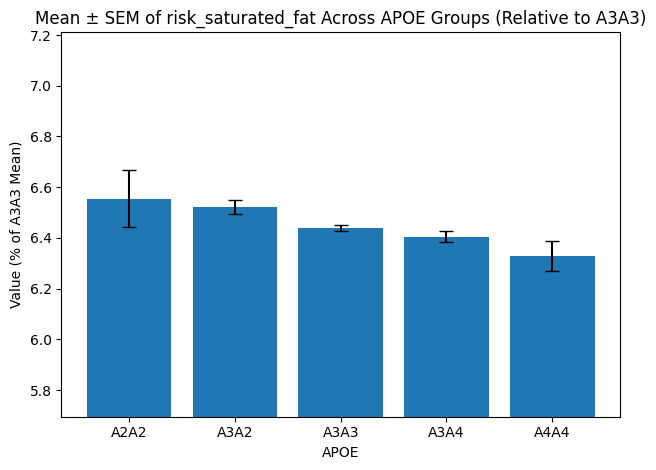

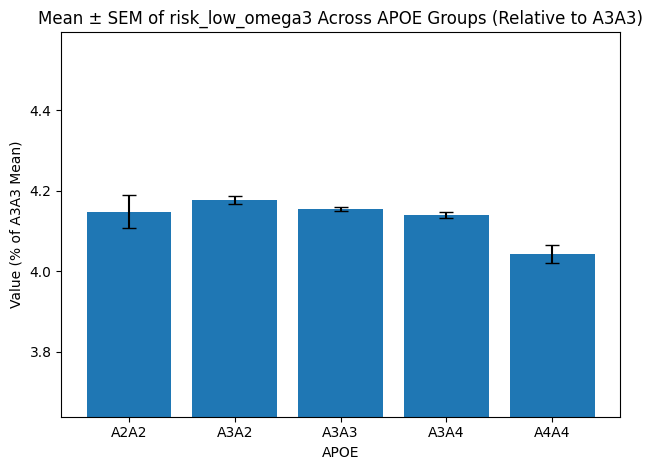

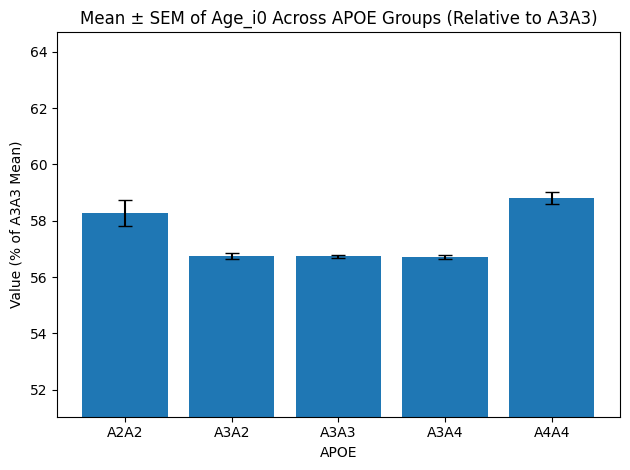

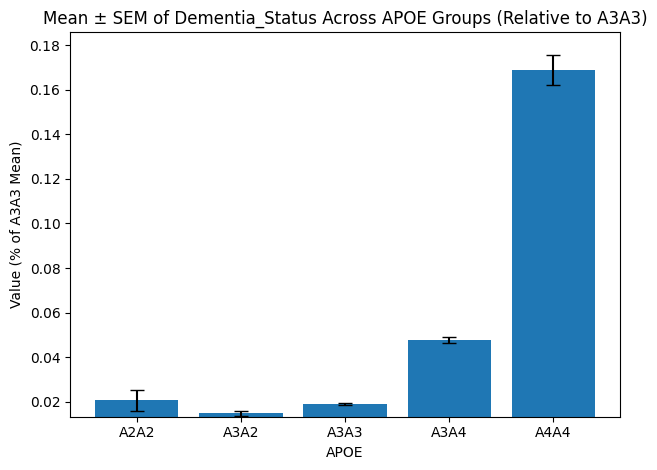

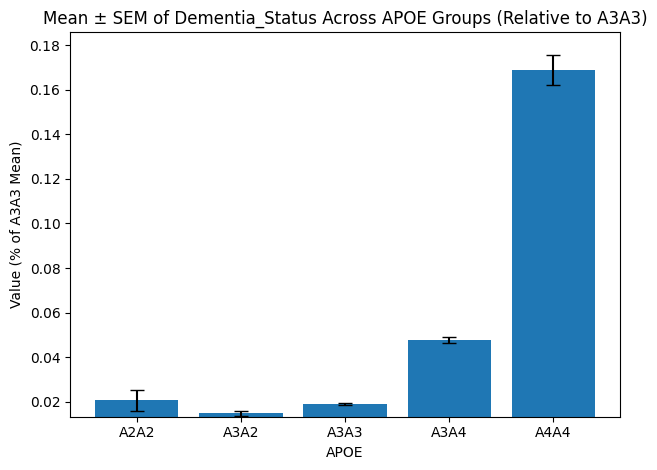

In [116]:
plot=True
if plot==True:
    for var in significant_vars:
        mm = regex.match(r'p\d*_', var)
        
        if mm is not None:
            cat=int(mm.group(0)[1:-1])
            name=get_category_descriptors_snake_case([cat])[cat]
        else:
            name = var
        
        subset = plot_data_melted[plot_data_melted['Variable'] == var]
        # Calculate mean and SEM for each APOE group
        means = subset.groupby('APOE')['Value'].mean()
        sems = subset.groupby('APOE')['Value'].sem()
        apoe_levels = means.index.tolist()
        plt.bar(apoe_levels, means, yerr=sems, capsize=5)
        plt.title(f'Mean ± SEM of {name} Across APOE Groups (Relative to A3A3)')
        plt.ylim([means.min()*0.9, means.max()*1.1])
        plt.ylabel('Value (% of A3A3 Mean)')
        plt.xlabel('APOE')
        plt.tight_layout()
        plt.show()

In [421]:
        model = sm.Logit(tmp[col].astype(bool), 
                         sm.add_constant(
                             pd.get_dummies(tmp[['APOE', 'Age_i0']], drop_first=True)
                         ).astype(float)).fit(disp=0)

/home/eduff/miniconda3/envs/pytorch/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/eduff/miniconda3/envs/pytorch/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/eduff/miniconda3/envs/pytorch/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/eduff/miniconda3/envs/pytorch/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be ide

In [431]:
significant_cat_vars


['prospective_memory',
 'average_total_household_income_before_tax_i0',
 'frequency_of_friend_family_visits_i0',
 'diabetes_diagnosed_by_doctor_i0',
 'rs429358',
 'rs7412',
 'A4',
 'Primary_Dementia_Diagnosis',
 'death_dementia_subtypes',
 'death_Primary_Dementia_Diagnosis']

In [26]:
significant__vars

NameError: name 'significant__vars' is not defined

In [382]:
significant_vars_OLINK= significant_vars.copy()

In [ ]:
for col in ['APOE4_signature_score']:
    groups = [RF[RF['APOE'] == apoe][col].dropna() for apoe in [a in RF['APOE'].unique() if a != nan]]
    if len(groups) > 1 and all(len(g) > 1 for g in groups):
        fval, pval = stats.f_oneway(*groups)
        if pval < 0.05:
            significant_vars.append(col)
            


SyntaxError: expected 'else' after 'if' expression (2276306235.py, line 2)

In [ ]:
means.max()

APOE
A2A2   NaN
A3A2   NaN
A3A3   NaN
A3A4   NaN
A4A4   NaN
Name: Percent_Relative, dtype: float64

In [ ]:
subset.groupby('APOE')

In [ ]:
from tabpfn_extensions.rf_pfn import (
    RandomForestTabPFNClassifier,
    RandomForestTabPFNRegressor,
)

from tabpfn_extensions import TabPFNClassifier, TabPFNRegressor

# ----------------------------
# Classification - Strategy 1: Random Forest Preprocessing
# ----------------------------

clf_base = TabPFNClassifier(
    ignore_pretraining_limits=True,
    inference_config = {"SUBSAMPLE_SAMPLES": 10000} # Needs to be set low so that not OOM on fitting intermediate nodes
)

tabpfn_tree_clf = RandomForestTabPFNClassifier(
    tabpfn=clf_base,
    verbose=1,
    max_predict_time=60, # Will fit for one minute
    fit_nodes=True, # Wheather or not to fit intermediate nodes
    adaptive_tree=True, # Whather or not to validate if adding a leaf helps or not
  )

In [ ]:
# ----------------------------
# Classification - Strategy 2: Subsampled Ensemble using TabPFNClassifier
# ----------------------------
print("\n--- Classification: Strategy 1 (Subsampled Ensemble) ---")
tabpfn_subsample_clf = TabPFNClassifier(
    ignore_pretraining_limits=True,  # (bool) Allows the use of datasets larger than pretraining limits.
    n_estimators=32,                 # (int) Number of estimators for ensembling; improves accuracy with higher values.
    inference_config={
        "SUBSAMPLE_SAMPLES": 10000  # (int) Maximum number of samples per inference step to manage memory usage.
    },
)


--- Classification: Strategy 1 (Subsampled Ensemble) ---


In [ ]:
# Compare different machine learning models by training each one multiple times
# on different parts of the data and averaging their performance scores for a
# more reliable performance estimate

assert len(np.unique(y)) <= 10 # Is classification?

# Define models
models_class = [
    ('TabPFN RF', tabpfn_tree_clf),
   # ('TabPFN Subsample', tabpfn_subsample_clf),
    ('XGBoost', XGBClassifier()),
    ('CatBoost', CatBoostClassifier(random_state=42, verbose=0)),
    ('RandomForest', RandomForestClassifier(random_state=42)),
]

# Calculate scores
cv = KFold(random_state=42, n_splits=2, shuffle=True)
scoring = 'roc_auc_ovr' if len(np.unique(y)) > 2 else 'roc_auc'
scores_raw_class = {name: cross_val_score(model, X.iloc[:20000,:], y[:20000], cv=cv, scoring=scoring, verbose=1)
          for name, model in models_class}
scores_class = {name: scores_raw_class[name].mean()
          for name, model in models_class}

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 12.0min finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   21.7s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.9min finished


In [ ]:
tabpfn_subsample_clf?

Type:           TabPFNClassifier
String form:   
TabPFNClassifier(ignore_pretraining_limits=True,
                 inference_config={'SUBSAMPLE_SAMPLES': 10000},
                 n_estimators=32)
File:           ~/tabpfn/src/tabpfn/classifier.py
Docstring:      TabPFNClassifier class.
Init docstring:
A TabPFN interface for classification.

Args:
    n_estimators:
        The number of estimators in the TabPFN ensemble. We aggregate the
         predictions of `n_estimators`-many forward passes of TabPFN. Each
         forward pass has (slightly) different input data. Think of this as an
         ensemble of `n_estimators`-many "prompts" of the input data.

    categorical_features_indices:
        The indices of the columns that are suggested to be treated as
        categorical. If `None`, the model will infer the categorical columns.
        If provided, we might ignore some of the suggestion to better fit the
        data seen during pre-training.

        !!! note
            The i

In [466]:
del ukb671849

In [33]:
# ukb671849: imaging
ukb671849=pd.read_csv('/mnt/data/eduff/biobank/phenotype/origs/ukb671849_OLINK.csv')
ukb671849.set_index('eid', inplace=True)
# ukb671140: etc
#ukb671140=pd.read_csv('/mnt/data/eduff/biobank/phenotype/origs/ukb671140_OLINK.csv')
#ukb671140.set_index('eid', inplace=True)
# ukb671337: dementia
#ukb671337=pd.read_csv('/mnt/data/eduff/biobank/phenotype/origs/ukb671337_OLINK.csv')
#ukb671337.set_index('eid', inplace=True)

#test.drop(columns=['Unnamed: 0'], inplace=True)
#est.drop(columns=['Unnamed: 0.1'], inplace=True)
#test=pd.read_csv('/mnt/data/eduff/biobank/phenotype/origs/ukb671337_OLINK.csv')
#test.set_index('eid', inplace=True)
#test=pd.read_csv('/mnt/data/eduff/biobank/phenotype/origs/ukb671140_OLINK.csv')
#test.set_index('eid', inplace=True)




/tmp/ipykernel_166033/2968786004.py:2: DtypeWarning: Columns (42,1170,1171,1172,1173,1174,1175,1176,1177,1178,1242,1243,1244,1245,1246,1247,1248,1249,1250,1301,1302,1303,1304,1305,1306,1307,1312,1313,1314,1315,1316,1317,1318,1702,1703,1704,2208,2209,2210,2211,2212,2213,2214,2215,2216,2217,2218,2219,2220,2221,2222,2238,2239,2240,2241,2242,2243,2244,2245,2246,2247,2248,2249,2250,2251,2252,2808,2809,2810,2811,2812,2813,2814,2815,2816,2817,2818,2819,2820,2821,2822,2838,2839,2840,2841,2842,2843,2844,2845,2846,2847,2848,2849,2850,2851,2852,3368,3369,3370,3371,3372,3373,3374,3375,3393,3394,3395,3396,3397,3398,3399,3400,3401,3402,3403,3404,3405,3406,3407,3409,3410,3411,3412,3413,3414,3415,3416,3417,3418,3419,3420,3421,3422,3423,3426,3666,3668,3678,3680,3702,3704,4969,4970,4971,4972,4973,4974,4975,4976,4977,4978,4979,4980,4981,4982,4983,4984,4985,4986,4987,4988,4989,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999,5000,5001,5002,5003,5004,5005,5006,5007,5008,5009,5010,5011,5012,5013,5014,5015,

In [ ]:
df4=pd.read_csv('/mnt/data/eduff/biobank/phenotype/origs/all_OLINK.csv')

In [34]:
df4=df4.merge(ukb671849,left_index=True,right_index=True, suffixes=('', '_remove'),how='inner')

In [37]:
df4.to_csv('/mnt/data/eduff/biobank/phenotype/origs/all_OLINK.csv')

In [ ]:
df4=RF.merge(ukb671337,left_index=True,right_index=True, suffixes=('', '_remove'),how='inner')
df4.drop([i for i in df4.columns if 'remove' in i], axis=1, inplace=True)
df4=RF.merge(ukb671140,left_index=True,right_index=True, suffixes=('', '_remove'),how='inner')
df4.drop([i for i in df4.columns if 'remove' in i], axis=1, inplace=True)

In [ ]:
df4=RF.merge(ukb671337,left_index=True,right_index=True, suffixes=('', '_remove'),how='inner')


In [25]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                             _: 11.6 GiB
                           ___: 11.6 GiB
                     ukb671140: 11.6 GiB
                           _18: 11.6 GiB
                           _23: 11.6 GiB
                            __:  7.2 GiB
                     ukb671337:  7.2 GiB
                           _17:  7.2 GiB
                           _19:  7.2 GiB
                            df:  1.2 GiB


,3-0.0,3-1.0,3-2.0,3-3.0,4-0.0,4-1.0,4-2.0,4-3.0,5-0.0,5-1.0,...,105010-2.0,105010-3.0,105010-4.0,105030-0.0,105030-1.0,105030-2.0,105030-3.0,105030-4.0,110005-0.0,110006-0.0
eid,,,,,,,,,,,,,,,,,,,,,
1000037,221.0,NaN,NaN,NaN,505.0,NaN,NaN,NaN,297.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000221,519.0,NaN,NaN,NaN,359.0,NaN,NaN,NaN,465.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000326,632.0,NaN,NaN,NaN,586.0,NaN,NaN,NaN,384.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000662,368.0,NaN,NaN,NaN,387.0,NaN,NaN,NaN,399.0,NaN,...,2011-08-27T12:23:19,2011-11-22T14:44:37,NaN,NaN,NaN,2011-08-27T12:05:32,2011-11-22T14:33:00,NaN,2.0,2013-10-28
1000823,411.0,NaN,NaN,NaN,327.0,NaN,NaN,NaN,232.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6023823,696.0,NaN,NaN,NaN,443.0,NaN,NaN,NaN,245.0,NaN,...,NaN,2011-11-10T20:03:00,2012-05-14T20:07:40,NaN,NaN,NaN,2011-11-10T19:46:17,2012-05-14T19:43:52,0.0,2015-11-26
6023922,413.0,NaN,NaN,NaN,446.0,NaN,NaN,NaN,264.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6024013,309.0,NaN,NaN,NaN,443.0,NaN,NaN,NaN,181.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
RF=pd.read_csv('Olink_cohort_APOE_Dementia.csv')


df=OLINK.merge(RF.loc[:,['A4','Dementia_Status']],suffixes =('', '_RF'), left_index=True, right_index=True, how='inner')


,reaction_time,fluid_intelligence,incorrect_match,prospective_memory,APOE4_signature_score,HSV1_APOE4_synergy_score,HSV1_APOE4_synergy_score_subset,Sex,p34,p46_i0,...,Dementia_source,Year_i0,Age_followup,Year_dementia,Age_dementia,Death_Status,Year_death,Age_death,Age_category,Age_centered
eid,,,,,,,,,,,,,,,,,,,,,
1000221,477.0,NaN,7.0,NaN,-6.983413,-0.013461,-0.067825,0,1945,12.0,...,NaN,2008,78,NaN,NaN,False,NaN,NaN,>65,6.737489
1001193,652.0,NaN,4.0,NaN,-0.376849,0.028785,-0.026762,1,1957,34.0,...,NaN,2008,67,NaN,NaN,False,NaN,NaN,>65,-4.262511
1001694,524.0,7.0,0.0,2.0,4.786649,0.046793,0.087276,0,1946,20.0,...,NaN,2009,78,NaN,NaN,False,NaN,NaN,>65,6.737489
1001983,516.0,NaN,3.0,NaN,-1.378179,0.032635,0.016521,0,1951,26.0,...,NaN,2009,72,NaN,NaN,False,NaN,NaN,>65,0.737489
1002756,441.0,8.0,5.0,1.0,-0.684556,0.078838,-0.004045,0,1947,22.0,...,NaN,2009,77,NaN,NaN,False,NaN,NaN,>65,5.737489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6023092,504.0,3.0,7.0,2.0,1.458263,-0.028047,0.046392,0,1957,18.0,...,NaN,2010,67,NaN,NaN,False,NaN,NaN,>65,-4.262511
6023355,450.0,NaN,4.0,NaN,3.849532,0.111515,0.055934,0,1955,30.0,...,NaN,2008,68,NaN,NaN,False,NaN,NaN,>65,-3.262511
6023438,422.0,NaN,5.0,NaN,-0.842668,-0.015474,-0.053944,0,1958,29.0,...,NaN,2009,65,NaN,NaN,False,NaN,NaN,≤65,-6.262511


Text(0.5, 1.0, 'Model Comparison - 5-fold Cross-validation')

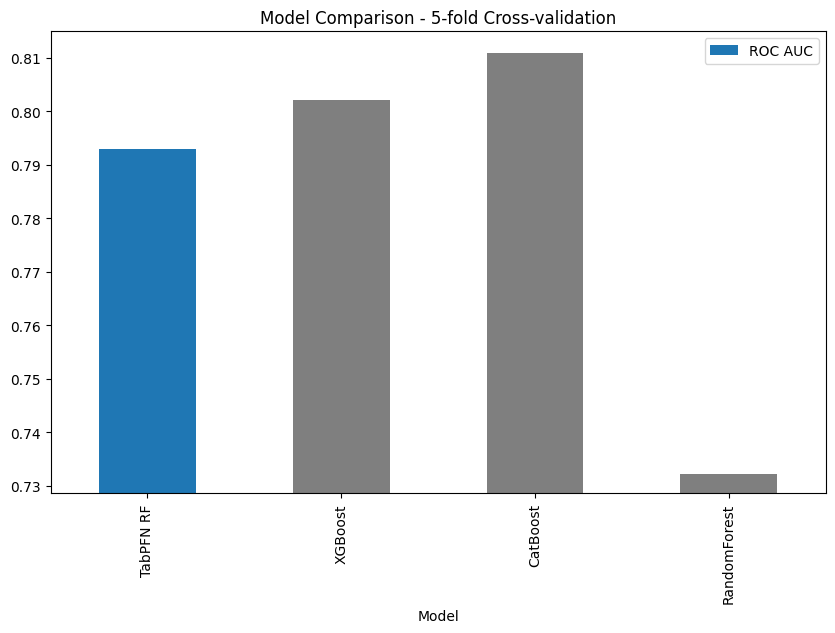

In [ ]:
# Plot results
df = pd.DataFrame(list(scores_class.items()), columns=['Model', 'ROC AUC'])
colors = ['tab:blue' if 'RF' in name else ('tab:red' if 'sample' in name else 'tab:gray') for (name, _) in models_class]
ax = df.plot(x='Model', y='ROC AUC', kind='bar', figsize=(10, 6), color=colors)
ax.set_ylim(df['ROC AUC'].min() * 0.995, min(1.0, df['ROC AUC'].max() * 1.005))
ax.set_title('Model Comparison - 5-fold Cross-validation')

### Regression

We now compare the regression performance of TabPFN, [XGBoost](https://xgboost.readthedocs.io/en/stable/), and [CatBoost](https://catboost.ai/) on the toy data from scikit-learn.

We measure regression performance using [Root Mean Squared Error](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.root_mean_squared_error.html).

In [ ]:
# Load the Census Income dataset
#df = fetch_openml(data_id=42731, as_frame=True) # 20k samples
# Diamonds
df = fetch_openml(data_id=42225, as_frame=True) # 50k samples
# Load the YearPredictionMSD dataset
#df = fetch_openml(data_id=42724, as_frame=True)

X, y = df.data, df.target

# Convert all categorical columns to numeric
for col in X.select_dtypes(['category']).columns:
    X[col] = X[col].cat.codes

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Print dataset description
display(Markdown(df['DESCR']))

display(X)

/tmp/ipykernel_98828/26695484.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].cat.codes


This classic dataset contains the prices and other attributes of almost 54,000 diamonds. It's a great dataset for beginners learning to work with data analysis and visualization.

Content
price price in US dollars (\$326--\$18,823)

carat weight of the diamond (0.2--5.01)

cut quality of the cut (Fair, Good, Very Good, Premium, Ideal)

color diamond colour, from J (worst) to D (best)

clarity a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

x length in mm (0--10.74)

y width in mm (0--58.9)

z depth in mm (0--31.8)

depth total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)

table width of top of diamond relative to widest point (43--95)

Downloaded from openml.org.

,carat,cut,color,clarity,depth,table,x,y,z
0,0.23,3,1,3,61.5,55.0,3.95,3.98,2.43
1,0.21,4,1,2,59.8,61.0,3.89,3.84,2.31
2,0.23,2,1,4,56.9,65.0,4.05,4.07,2.31
3,0.29,4,5,5,62.4,58.0,4.20,4.23,2.63
4,0.31,2,6,3,63.3,58.0,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...
53935,0.72,3,0,2,60.8,57.0,5.75,5.76,3.50
53936,0.72,2,0,2,63.1,55.0,5.69,5.75,3.61
53937,0.70,0,0,2,62.8,60.0,5.66,5.68,3.56
53938,0.86,4,4,3,61.0,58.0,6.15,6.12,3.74


In [ ]:
from tabpfn_extensions.rf_pfn import (
    RandomForestTabPFNClassifier,
    RandomForestTabPFNRegressor,
)

from tabpfn_extensions import TabPFNClassifier, TabPFNRegressor

# ----------------------------
# Classification - Strategy 2: Random Forest Preprocessing
# ----------------------------

reg_base = TabPFNRegressor(
    ignore_pretraining_limits=True,
    inference_config = {"SUBSAMPLE_SAMPLES": 10000} # Needs to be set low so that not OOM on fitting intermediate nodes
)

tabpfn_tree_reg = RandomForestTabPFNRegressor(
    tabpfn=reg_base,
    verbose=1,
    max_predict_time=60, # Will fit for one minute
    fit_nodes=True, # Wheather or not to fit intermediate nodes
    adaptive_tree=True, # Whather or not to validate if adding a leaf helps or not
  )

In [ ]:
# ----------------------------
# Regression - Strategy 2: Subsampled Ensemble using TabPFNRegressor
# ----------------------------
print("\n--- Regression: Strategy 1 (Subsampled Ensemble) ---")
tabpfn_subsample_reg = TabPFNRegressor(
    ignore_pretraining_limits=True,  # (bool) Enables handling datasets beyond pretraining constraints.
    n_estimators=32,                 # (int) Number of estimators in the ensemble for robustness.
    inference_config={
        "SUBSAMPLE_SAMPLES": 10000  # (int) Controls sample subsampling per inference to avoid OOM errors.
    },
)


--- Regression: Strategy 1 (Subsampled Ensemble) ---


In [ ]:
assert len(np.unique(y)) >= 10 # Is regression?

# Compare different machine learning models by training each one multiple times
# on different parts of the data and averaging their performance scores for a
# more reliable performance estimate

# Define models
models_reg = [
    ('TabPFN RF', tabpfn_tree_reg),
    ('TabPFN Subsample', tabpfn_subsample_reg),
    ('RandomForest', RandomForestRegressor(random_state=42)),
    ('XGBoost', XGBRegressor(random_state=42)),
    ('CatBoost', CatBoostRegressor(random_state=42, verbose=0))
]

# Calculate scores
scoring = 'r2'
cv = KFold(random_state=0, n_splits=3, shuffle=True)
scores_raw_reg = {name: cross_val_score(model, X, y, cv=cv, scoring=scoring, verbose=2)
          for name, model in models_reg}
scores_reg = {name: scores_raw_reg[name].mean()
          for name, model in models_reg}

/home/eduff/tabpfn/src/tabpfn/regressor.py:450: UserWarning: Number of samples 28768 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(
/home/eduff/tabpfn/src/tabpfn/regressor.py:450: UserWarning: Number of samples 35960 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(


[CV] END .................................................... total time= 1.2min


/home/eduff/tabpfn/src/tabpfn/regressor.py:450: UserWarning: Number of samples 28768 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(
/home/eduff/miniconda3/envs/pytorch/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/eduff/miniconda3/envs/pytorch/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/eduff/miniconda3/envs/pytorch/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home

[CV] END .................................................... total time= 1.1min


/home/eduff/tabpfn/src/tabpfn/regressor.py:450: UserWarning: Number of samples 28768 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(
/home/eduff/tabpfn/src/tabpfn/regressor.py:450: UserWarning: Number of samples 35960 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(


[CV] END .................................................... total time= 1.1min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.4min finished
/home/eduff/tabpfn/src/tabpfn/regressor.py:450: UserWarning: Number of samples 35960 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(


[CV] END .................................................... total time=  18.0s


/home/eduff/tabpfn/src/tabpfn/regressor.py:450: UserWarning: Number of samples 35960 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(


[CV] END .................................................... total time=  17.6s


/home/eduff/tabpfn/src/tabpfn/regressor.py:450: UserWarning: Number of samples 35960 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(


[CV] END .................................................... total time=  17.7s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   53.3s finished


[CV] END .................................................... total time=  14.2s
[CV] END .................................................... total time=  14.2s
[CV] END .................................................... total time=  14.2s
[CV] END .................................................... total time=   0.1s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   42.6s finished


[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s finished


[CV] END .................................................... total time=   3.1s
[CV] END .................................................... total time=   3.1s
[CV] END .................................................... total time=   3.1s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.3s finished


In [ ]:
scores_raw_reg_2 = {name: cross_val_score(model, X, y, cv=cv, scoring=scoring, verbose=2)
          for name, model in [('SVC',SVC())]}

[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished


ValueError: 
All the 2 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/home/eduff/miniconda3/envs/pytorch/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/eduff/miniconda3/envs/pytorch/lib/python3.13/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/eduff/miniconda3/envs/pytorch/lib/python3.13/site-packages/sklearn/svm/_base.py", line 190, in fit
    X, y = self._validate_data(
           ~~~~~~~~~~~~~~~~~~~^
        X,
        ^^
    ...<4 lines>...
        accept_large_sparse=False,
        ^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/home/eduff/miniconda3/envs/pytorch/lib/python3.13/site-packages/sklearn/base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "/home/eduff/miniconda3/envs/pytorch/lib/python3.13/site-packages/sklearn/utils/validation.py", line 1301, in check_X_y
    X = check_array(
        X,
    ...<12 lines>...
        input_name="X",
    )
  File "/home/eduff/miniconda3/envs/pytorch/lib/python3.13/site-packages/sklearn/utils/validation.py", line 1064, in check_array
    _assert_all_finite(
    ~~~~~~~~~~~~~~~~~~^
        array,
        ^^^^^^
    ...<2 lines>...
        allow_nan=force_all_finite == "allow-nan",
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/home/eduff/miniconda3/envs/pytorch/lib/python3.13/site-packages/sklearn/utils/validation.py", line 123, in _assert_all_finite
    _assert_all_finite_element_wise(
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^
        X,
        ^^
    ...<4 lines>...
        input_name=input_name,
        ^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/home/eduff/miniconda3/envs/pytorch/lib/python3.13/site-packages/sklearn/utils/validation.py", line 172, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
SVC does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


Text(0.5, 1.0, 'Model Comparison - 5-fold Cross-validation \n (Variance Explained)')

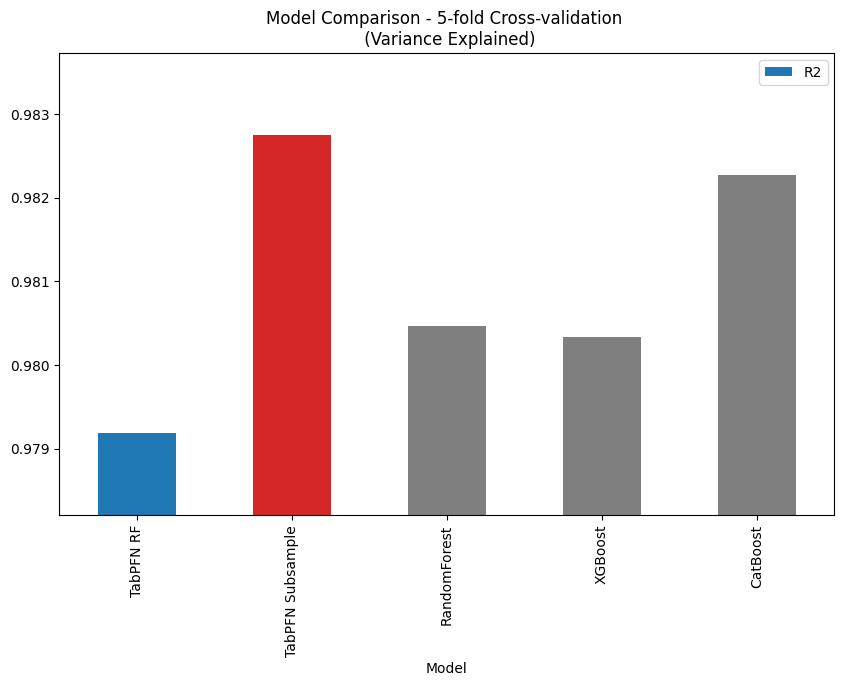

In [ ]:
# Plot results
colors = ['tab:blue' if 'RF' in name else ('tab:red' if 'sample' in name else 'tab:gray') for (name, _) in models_reg]
df = pd.DataFrame(list(scores_reg.items()), columns=['Model', 'R2'])
ax = df.plot(x='Model', y='R2', kind='bar', figsize=(10, 6), color=colors)
ax.set_ylim(df['R2'].min() * 0.999, df['R2'].max() * 1.001)
ax.set_title('Model Comparison - 5-fold Cross-validation \n (Variance Explained)')

## Generate Data

In [281]:
#  Copyright (c) Prior Labs GmbH 2025.
#  Licensed under the Apache License, Version 2.0

import torch
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

from tabpfn_extensions import TabPFNClassifier, unsupervised

# Load the breast cancer dataset
df = load_breast_cancer(return_X_y=False)
X, y = df["data"], df["target"]
#X, y = RF.iloc[:500,:15],RF['A4'][:500]
attribute_names = df["feature_names"]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.5,
    random_state=42,
)

# Initialize TabPFN models
# Use parameters that work with both TabPFN and TabPFN-client
clf = TabPFNClassifier(n_estimators=3)

# Import TabPFNRegressor for numerical features
from tabpfn_extensions import TabPFNRegressor

reg = TabPFNRegressor(n_estimators=3)

# Initialize unsupervised model
model_unsupervised = unsupervised.TabPFNUnsupervisedModel(
    tabpfn_clf=clf,
    tabpfn_reg=reg,
)

# Select features for analysis (e.g., first two features)
feature_indices = [0, 1]

# Create and run synthetic experiment
exp_synthetic = unsupervised.experiments.GenerateSyntheticDataExperiment(
    task_type="unsupervised",
)

# Convert data to torch tensors
X_tensor = torch.tensor(np.array(X_train).astype(float), dtype=torch.float32)
y_tensor = torch.tensor(np.array(y_train).astype(float), dtype=torch.float32)
sdf
# Run the experiment
results = exp_synthetic.run(
    tabpfn=model_unsupervised,
    X=X_tensor,
    y=y_tensor,
    attribute_names=attribute_names,
    temp=1.0,
    n_samples=X_train.shape[0] * 3,  # Generate 3x original samples
    indices=feature_indices,
)

NameError: name 'sdf' is not defined

In [310]:
ids=RF.index[(RF.isna().sum(axis=1)<30)]
list(RF.loc[ids,:].columns)

['reaction_time',
 'fluid_intelligence',
 'incorrect_match',
 'prospective_memory',
 'APOE4_signature_score',
 'HSV1_APOE4_synergy_score',
 'HSV1_APOE4_synergy_score_subset',
 'Sex',
 'p34',
 'p46_i0',
 'p46_i1',
 'p46_i2',
 'p46_i3',
 'p47_i0',
 'p47_i1',
 'p47_i2',
 'p47_i3',
 'p48_i0',
 'p48_i1',
 'p48_i2',
 'p48_i3',
 'p49_i0',
 'p49_i1',
 'p49_i2',
 'p49_i3',
 'p50_i0',
 'p50_i1',
 'p50_i2',
 'p50_i3',
 'p52',
 'p53_i0',
 'p53_i1',
 'p53_i2',
 'p53_i3',
 'p709_i0',
 'p709_i1',
 'p709_i2',
 'p709_i3',
 'p738_i0',
 'p738_i1',
 'p738_i2',
 'p738_i3',
 'p845_i0',
 'p845_i1',
 'p845_i2',
 'p884_i0',
 'p884_i1',
 'p884_i2',
 'p884_i3',
 'p894_i0',
 'p894_i1',
 'p894_i2',
 'p894_i3',
 'p904_i0',
 'p904_i1',
 'p904_i2',
 'p904_i3',
 'p914_i0',
 'p914_i1',
 'p914_i2',
 'p914_i3',
 'p1031_i0',
 'p1031_i1',
 'p1031_i2',
 'p1031_i3',
 'p1070_i0',
 'p1070_i1',
 'p1070_i2',
 'p1070_i3',
 'p1239_i0',
 'p1239_i1',
 'p1239_i2',
 'p1239_i3',
 'p1558_i0',
 'p1558_i1',
 'p1558_i2',
 'p1558_i3',
 'p20

In [ ]:
from tabpfn import TabPFNClassifier, TabPFNRegressor
from tabpfn_extensions.unsupervised import TabPFNUnsupervisedModel
clf = TabPFNClassifier()
reg = TabPFNRegressor()
model = TabPFNUnsupervisedModel(tabpfn_clf=clf, tabpfn_reg=reg)
model.fit(X_tensor)

TabPFNUnsupervisedModel(tabpfn_clf=TabPFNClassifier(),
                        tabpfn_reg=TabPFNRegressor())

In [ ]:
#X_tensor = torch.tensor(np.array(X_test).astype(float), dtype=torch.float32)
model.impute(X_tensor[:3,:])

 33%|███████████████████████████████████████▎                                                                              | 10/30 [04:34<09:09, 27.49s/it]


KeyboardInterrupt: 

In [ ]:
X_tensor[:3,:].shape

tensor([[ 4.8800e+02,         nan,  6.0000e+00,         nan, -3.0074e+00,
         -8.3751e-02,  1.2185e-02,  1.0000e+00,  1.9550e+03,  5.0000e+01,
                 nan,         nan,         nan,  5.8000e+01,         nan,
                 nan,         nan,  1.1200e+02,         nan,         nan,
                 nan,  1.1300e+02,         nan,         nan,         nan,
          1.8400e+02,         nan,         nan,         nan,  6.0000e+00],
        [ 5.4700e+02,         nan,  5.0000e+00,         nan, -2.7265e+00,
         -1.4752e-01, -3.8844e-02,  0.0000e+00,  1.9610e+03,  3.4000e+01,
                 nan,         nan,         nan,  3.0000e+01,         nan,
                 nan,         nan,  7.6000e+01,         nan,         nan,
                 nan,  9.4000e+01,         nan,         nan,         nan,
          1.7100e+02,         nan,         nan,         nan,  5.0000e+00],
        [ 5.6700e+02,  3.0000e+00,  6.0000e+00,  0.0000e+00,  4.9547e+00,
         -1.8788e-01, -1.7286e-02,  

In [ ]:
model.impute(X_tensor)

  0%|                                                                                                                               | 0/30 [00:00<?, ?it/s]


TypeError: zeros_like(): argument 'input' (position 1) must be Tensor, not DataFrame

In [ ]:
tmp=np.array(X_train).astype(float)
tmp

array([[476. ,   7. ,   3. , ..., 178.8,   nan,   7. ],
       [480. ,   5. ,   5. , ...,   nan,   nan,   6. ],
       [429. ,   5. ,   1. , ...,   nan,   nan,  10. ],
       ...,
       [578. ,   nan,   1. , ...,   nan,   nan,  12. ],
       [375. ,   6. ,   3. , ...,   nan,   nan,   4. ],
       [418. ,   nan,   4. , ...,   nan,   nan,   8. ]], shape=(250, 30))

In [ ]:
import pandas as pd
import re

def to_snake_case(text: str) -> str:
    """Converts a string to snake_case.

    Args:
        text: The input string.

    Returns:
        The snake_case version of the string.
    """
    if not text:
        return ""
    # Replace non-alphanumeric characters (except spaces) with a space
    text = re.sub(r'[^\w\s-]', ' ', text)
    # Replace hyphens with spaces
    text = text.replace('-', ' ')
    # Replace multiple spaces with a single underscore
    text = re.sub(r'\s+', '_', text)
    # Convert to lowercase
    return text.lower().strip('_')

def get_category_descriptors_snake_case(
    category_ids: list[int],
    category_file_path: str = 'categories.tsv'
) -> dict[int, str]:
    """
    Converts UK Biobank category IDs to snake_case descriptors.

    Args:
        category_ids: A list of UK Biobank category IDs (integers).
        category_file_path: The file path to the UK Biobank categories TSV file.

    Returns:
        A dictionary mapping category IDs to their snake_case descriptors.
        Returns an empty string for IDs not found.
    """
    descriptors = {}
    try:
        # Load the category data
        df = pd.read_csv(category_file_path, sep='\t', usecols=['field_id', 'title'])
        # Create a dictionary for quick lookups
        category_map = df.set_index('field_id')['title'].to_dict()

        for cat_id in category_ids:
            title = category_map.get(cat_id)
            if title:
                descriptors[cat_id] = to_snake_case(title)
            else:
                descriptors[cat_id] = "" # Or handle as "not_found" or None
                print(f"Warning: Category ID {cat_id} not found in {category_file_path}")

    except FileNotFoundError:
        print(f"Error: The file {category_file_path} was not found.")
        return {cat_id: "file_not_found" for cat_id in category_ids}
    except KeyError:
        print("Error: The TSV file must contain 'category_id' and 'category_title' columns.")
        return {cat_id: "key_error_in_file" for cat_id in category_ids}
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return {cat_id: "unexpected_error" for cat_id in category_ids}

    return descriptors

if __name__ == '__main__':
    # --- How to use ---

    # 1. Download the 'categories.tsv' file from the UK Biobank Data Showcase.
    #    (e.g., from https://biobank.ndph.ox.ac.uk/showcase/browse.cgi)
    #    Make sure it's in the same directory as this script, or provide the correct path.

    # 2. List the category IDs you want to convert
    example_ids_to_convert = [100, 1001, 2000, 100092] # Example IDs

    # 3. Call the function
    snake_case_descriptors = get_category_descriptors_snake_case(example_ids_to_convert)

    # 4. Print the results
    if snake_case_descriptors:
        print("\n--- Results ---")
        for cat_id, descriptor in snake_case_descriptors.items():
            print(f"Category ID: {cat_id} -> Descriptor: {descriptor}")

    # Example with a non-existent file path for error handling demonstration
    print("\n--- Example with non-existent file ---")
    non_existent_file_descriptors = get_category_descriptors_snake_case(
        [100],
        "non_existent_categories.tsv"
    )
    for cat_id, descriptor in non_existent_file_descriptors.items():
            print(f"Category ID: {cat_id} -> Descriptor: {descriptor}")

    # Example with an ID that might not be in a typical file
    print("\n--- Example with potentially missing ID ---")
    missing_id_descriptors = get_category_descriptors_snake_case([9999999])
    for cat_id, descriptor in missing_id_descriptors.items():
        print(f"Category ID: {cat_id} -> Descriptor: {descriptor}")


--- Results ---
Category ID: 100 -> Descriptor: 
Category ID: 1001 -> Descriptor: duration_of_strenuous_sports
Category ID: 2000 -> Descriptor: worry_too_long_after_embarrassment
Category ID: 100092 -> Descriptor: 

--- Example with non-existent file ---
Error: The file non_existent_categories.tsv was not found.
Category ID: 100 -> Descriptor: file_not_found

--- Example with potentially missing ID ---
Category ID: 9999999 -> Descriptor: 


In [391]:
ll=[]
RF2=RF.copy()
for var in RF.columns:
    mm = regex.match(r'p\d*_', var)
    
        
    if mm is not None:
        suffix = var[mm.span()[1]:]
        cat=int(mm.group(0)[1:-1])
        #ll.append(int(mm.group(0)[1:-1]))
        name=get_category_descriptors_snake_case([cat])
        RF2=RF2.rename(columns={var: name[cat]+'_'+suffix})
        #
    #else:
    #    name = var

In [390]:
var='p21001_i1'
mm = regex.match(r'p\d*_', var)
var[mm.span()[1]:]
suffix = regex.match(r'_p\d*$', var)
suffix

In [ ]:
dd=get_category_descriptors_snake_case(ll)
RF2=RF.copy()
for a in ll:
    RF2=RF2.rename(columns={f'p{a}_': dd[a]}, inplace=True)   

In [337]:
RF2.rename(columns={'reaction_time': 'test'}, inplace=True)

In [342]:
name

{21002: 'weight'}

In [340]:
RF2.columns

Index(['test', 'fluid_intelligence', 'incorrect_match', 'prospective_memory',
       'APOE4_signature_score', 'HSV1_APOE4_synergy_score',
       'HSV1_APOE4_synergy_score_subset', 'Sex', 'p34', 'p46_i0',
       ...
       'Dementia_source', 'Year_i0', 'Age_followup', 'Year_dementia',
       'Age_dementia', 'Death_Status', 'Year_death', 'Age_death',
       'Age_category', 'Age_centered'],
      dtype='object', length=183)

In [334]:
list(RF2.columns)

['reaction_time',
 'fluid_intelligence',
 'incorrect_match',
 'prospective_memory',
 'APOE4_signature_score',
 'HSV1_APOE4_synergy_score',
 'HSV1_APOE4_synergy_score_subset',
 'Sex',
 'p34',
 'p46_i0',
 'p46_i1',
 'p46_i2',
 'p46_i3',
 'p47_i0',
 'p47_i1',
 'p47_i2',
 'p47_i3',
 'p48_i0',
 'p48_i1',
 'p48_i2',
 'p48_i3',
 'p49_i0',
 'p49_i1',
 'p49_i2',
 'p49_i3',
 'p50_i0',
 'p50_i1',
 'p50_i2',
 'p50_i3',
 'p52',
 'p53_i0',
 'p53_i1',
 'p53_i2',
 'p53_i3',
 'p709_i0',
 'p709_i1',
 'p709_i2',
 'p709_i3',
 'p738_i0',
 'p738_i1',
 'p738_i2',
 'p738_i3',
 'p845_i0',
 'p845_i1',
 'p845_i2',
 'p884_i0',
 'p884_i1',
 'p884_i2',
 'p884_i3',
 'p894_i0',
 'p894_i1',
 'p894_i2',
 'p894_i3',
 'p904_i0',
 'p904_i1',
 'p904_i2',
 'p904_i3',
 'p914_i0',
 'p914_i1',
 'p914_i2',
 'p914_i3',
 'p1031_i0',
 'p1031_i1',
 'p1031_i2',
 'p1031_i3',
 'p1070_i0',
 'p1070_i1',
 'p1070_i2',
 'p1070_i3',
 'p1239_i0',
 'p1239_i1',
 'p1239_i2',
 'p1239_i3',
 'p1558_i0',
 'p1558_i1',
 'p1558_i2',
 'p1558_i3',
 'p20

In [ ]:
category_file_path: str = 'categories.tsv'
dfx= pd.read_csv(category_file_path, sep='\t', usecols=['field_id', 'title'])

In [ ]:
(dfx['field_id']==int('48')).sum()

np.int64(1)

In [379]:
RF2.columns.tolist()

['reaction_time',
 'fluid_intelligence',
 'incorrect_match',
 'prospective_memory',
 'APOE4_signature_score',
 'HSV1_APOE4_synergy_score',
 'HSV1_APOE4_synergy_score_subset',
 'Sex',
 'p34',
 'hand_grip_strength_left',
 'hand_grip_strength_left',
 'hand_grip_strength_left',
 'hand_grip_strength_left',
 'hand_grip_strength_right',
 'hand_grip_strength_right',
 'hand_grip_strength_right',
 'hand_grip_strength_right',
 'waist_circumference',
 'waist_circumference',
 'waist_circumference',
 'waist_circumference',
 'hip_circumference',
 'hip_circumference',
 'hip_circumference',
 'hip_circumference',
 'standing_height',
 'standing_height',
 'standing_height',
 'standing_height',
 'p52',
 'date_of_attending_assessment_centre',
 'date_of_attending_assessment_centre',
 'date_of_attending_assessment_centre',
 'date_of_attending_assessment_centre',
 'number_in_household',
 'number_in_household',
 'number_in_household',
 'number_in_household',
 'average_total_household_income_before_tax',
 'avera